# Analysis of the rent dataset

## Overview

Before we start analyzing the data and explaining our intentions, we need to get an overview of the existing data. No matter what we later want to do, we have to clean and prepocess our data in order to work with it 

### Load data

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.api.types import is_object_dtype
pd.set_option('display.max_columns', None)
%matplotlib inline

In [114]:
df = pd.read_csv("../data/testlizenz-tuebingen-dataliteracy4students_1700939273256.csv", sep=";", encoding='unicode_escape')
df.count()

angebot_id                    106720
anz_parken                     50795
anz_zimmer                    106517
aus_alarmanlage_janein        106720
aus_bad_dusche_janein         106720
                               ...  
oeig_dachgeschoss_janein      106720
enddate                       105945
aus_balkon_terrasse_janein    106720
aus_wintergarten_janein       106720
aus_garten_eigen_janein       106720
Length: 86, dtype: int64

In [115]:
# include year column
df['year'] = pd.to_datetime(df['startdate']).dt.year

In [116]:
df["month"] = pd.to_datetime(df['startdate']).dt.month

In [50]:
df

angebot_id  anz_parken anz_zimmer  aus_alarmanlage_janein  \
0      3594713336         NaN         2,                       0   
1      3594016393         NaN         2,                       0   
2      3593975043         NaN         1,                       0   
3      3594255459         1.0         3,                       0   
4      3594061704         1.0         3,                       0   
...           ...         ...        ...                     ...   
16003  3041045247         NaN        2,5                       0   
16004  3040210896         NaN         4,                       0   
16005  3058502400         NaN         7,                       0   
16006  3032926122         NaN         4,                       0   
16007  3043830326         NaN         7,                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
0                          1                        0   
1                          1                        0   
2                          0                        0   
3                          1                        1   
4                          0                        0   
...                      ...                      ...   
16003                      1                        0   
16004                      0                        1   
16005                      1                        0   
16006                      0                        0   
16007                      0                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
0                               0                     0   
1                               0                     0   
2                               0                     0   
3                               0                     1   
4                               0                     1   
...                           ...                   ...   
16003                           1                     1   
16004                           0                     1   
16005                           0                     0   
16006                           0                     1   
16007                           0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
...                         ...                        ...   
16003                         0                          0   
16004                         0                          0   
16005                         0                          0   
16006                         0                          0   
16007                         0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
...                           ...                        ...   
16003                           0                          0   
16004                           0                          0   
16005                           0                          1   
16006                           0                          0   
16007                           0                          1   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
0                            0                 NaN   
1                            0                 Gas   
2                            0                 NaN   
3                            0                 NaN   
4           

### How many houses and flats are in the dataset?

/tmp/ipykernel_2240955/4133854610.py:25: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


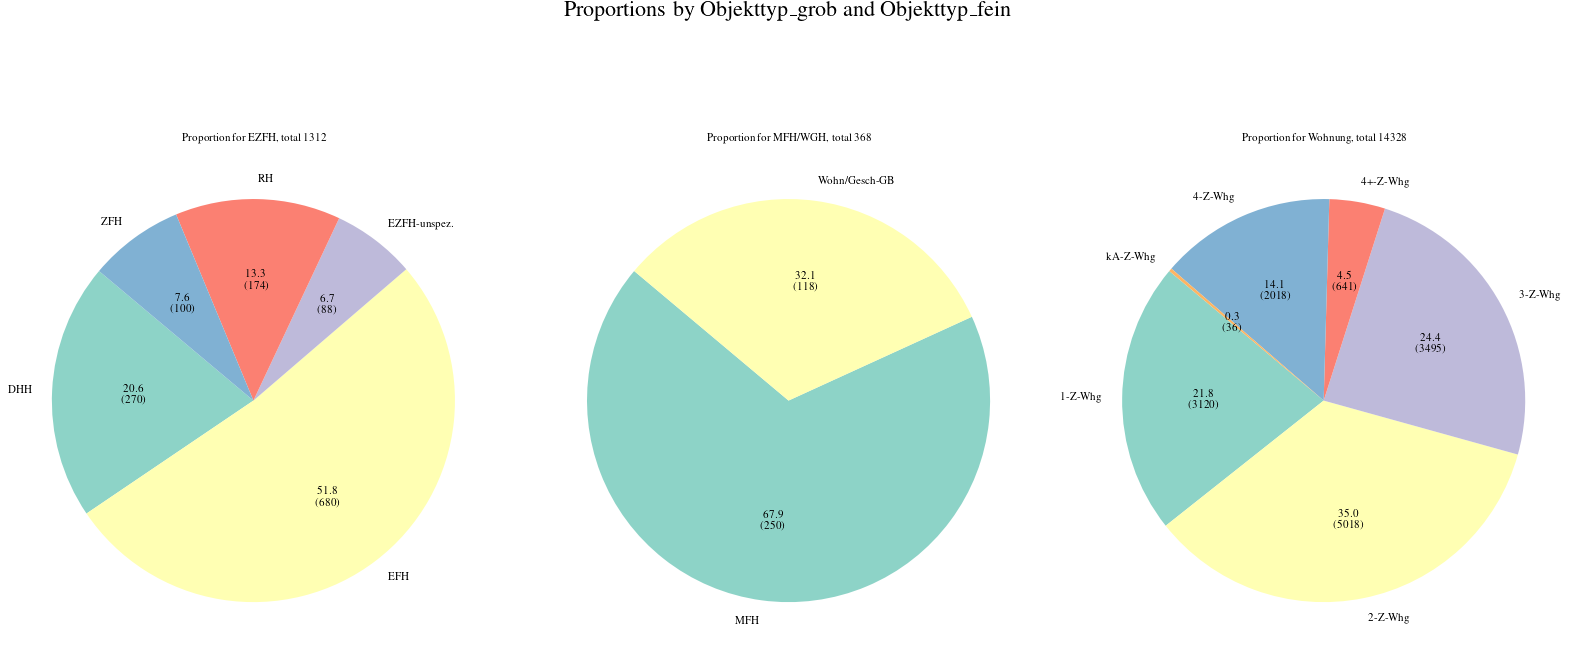

In [51]:
grouped_df = df.groupby(["objekttyp_grob", "objekttyp_fein"]).size().reset_index(name='count')
unique_grobs = grouped_df['objekttyp_grob'].unique()
fig, axes = plt.subplots(1, len(unique_grobs), figsize=(16, 8), subplot_kw=dict(aspect="equal"))
subtitle_text = ""
colors = plt.cm.Set3.colors  # Set color palette, adjust as needed

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"


for i, (grob, ax) in enumerate(zip(unique_grobs, axes.flatten())):
    grob_df = grouped_df[grouped_df['objekttyp_grob'] == grob]
    wedges, texts, autotexts = ax.pie(grob_df['count'], labels=grob_df['objekttyp_fein'], autopct=lambda pct: func(pct, grob_df['count']),
                                      colors=colors, startangle=140)
    ax.set_title(f'Proportion for {grob}, total {grob_df["count"].sum()}')

    # Increase the size of the labels and percentage values for better visibility
    for text in texts + autotexts:
        text.set_fontsize(8)
    # subtitle_text += f"Total for {grob}: {grob_df['count'].sum()} \n \n"

fig.suptitle(f'{subtitle_text}\n', fontsize=16, style='italic')
fig.suptitle('Proportions by Objekttyp_grob and Objekttyp_fein', fontsize=16)
fig.tight_layout()
plt.show()

#### We can clearly see that there are far more flats than houses.

### How many of those flats and houses are for sail, how many for rent?

In [52]:
df.groupby(["objekttyp_grob", "nachfrageart"]).size().reset_index(name='count')

objekttyp_grob nachfrageart  count
0           EZFH         kauf   1032
1           EZFH        miete    280
2        MFH/WGH         kauf    368
3        Wohnung         kauf   3754
4        Wohnung        miete  10574

-------------

# Where are those flats and houses located?
Now that we have generated a quick overview about our data, we will now focus on where these flats and houses actually are. We want to identify the region in Tübingen that has the most offers. Once we have categorized the data by region, we will also look at the price distribution in each region to compare the prices but simultaneously the regions.  

## Cleaning process..

*With which loaction do we start?*
Given are two different location attributes, *oadr_u2* being more specific than *oadr_u1*.

In [53]:
df_total_oadr_u1 = df.groupby(["oadr_u1"]).size().reset_index(name='count')
df_total_oadr_u1_count = df["oadr_u1"].isnull().sum()
print(f"Total number of OADR_U1: {df_total_oadr_u1['count'].sum()}")
print(f"Total number of OADR_U1 with no value: {df_total_oadr_u1_count}")
df.groupby(["oadr_u1"]).size().reset_index(name='count')

Total number of OADR_U1: 7845
Total number of OADR_U1 with no value: 2090


oadr_u1  count
0     Bebenhausen     40
1            Bühl    208
2     Derendingen    528
3       Hagelloch    124
4        Hirschau    288
5       Kilchberg     67
6         Lustnau    918
7       Pfrondorf    276
8        Tübingen   5135
9   Unterjesingen    192
10       Weilheim     69

In [54]:
df_total_oadr_u2 = df.groupby(["oadr_u2"]).size().reset_index(name='count')
df_total_oadr_u2_count = df["oadr_u2"].isnull().sum()
print(f"Total number of OADR_U2: {df_total_oadr_u2['count'].sum()}")
print(f"Total number of OADR_U2 with no value: {df_total_oadr_u2_count}")
df.groupby(["oadr_u2"]).size().reset_index(name='count')

Total number of OADR_U2: 6300
Total number of OADR_U2 with no value: 3635


oadr_u2  count
0                                  Aeule     48
1   Au/Unterer Wert/Französiches Viertel    386
2                            Bebenhausen     40
3                                   Bühl    208
4                             De-Zentrum     68
5                        Denzenberg/Sand    143
6               Feuerhägle/Mühlenviertel    211
7                            Gartenstadt     15
8                              Hagelloch    124
9                               Hirschau    288
10                             Kilchberg     67
11  Lustnau-Zentrum/Herrlesberg/Stäudach    327
12                              Neuhalde     84
13                             Pfrondorf    276
14             Schönblick/Waldhäuser Ost    463
15                              Südstadt    667
16                           Universität    822
17                         Unterjesingen    192
18                                 Wanne    429
19                              Weilheim     69
20                             Weststadt    714
21                               Zentrum    510
22                Österberg/Gartenstraße    149

In [55]:
df[df["oadr_u2"].isna()].groupby(["oadr_u1"]).size().reset_index(name='count')

oadr_u1  count
0  Derendingen    234
1      Lustnau    316
2     Tübingen    995

In [56]:
df[df["oadr_u1"].isna()].groupby(["oadr_u2"]).size().reset_index(name='count')

Empty DataFrame
Columns: [oadr_u2, count]
Index: []

In [57]:
df.groupby(["oadr_u2", "oadr_u1"]).size().reset_index(name='count').sort_values(by=['oadr_u1'], ascending=False)

oadr_u2        oadr_u1  count
19                              Weilheim       Weilheim     69
17                         Unterjesingen  Unterjesingen    192
22                Österberg/Gartenstraße       Tübingen    149
21                               Zentrum       Tübingen    510
20                             Weststadt       Tübingen    714
18                                 Wanne       Tübingen    429
16                           Universität       Tübingen    822
15                              Südstadt       Tübingen    667
14             Schönblick/Waldhäuser Ost       Tübingen    463
1   Au/Unterer Wert/Französiches Viertel       Tübingen    386
13                             Pfrondorf      Pfrondorf    276
12                              Neuhalde        Lustnau     84
0                                  Aeule        Lustnau     48
5                        Denzenberg/Sand        Lustnau    143
11  Lustnau-Zentrum/Herrlesberg/Stäudach        Lustnau    327
10                             Kilchberg      Kilchberg     67
9                               Hirschau       Hirschau    288
8                              Hagelloch      Hagelloch    124
7                            Gartenstadt    Derendingen     15
6               Feuerhägle/Mühlenviertel    Derendingen    211
4                             De-Zentrum    Derendingen     68
3                                   Bühl           Bühl    208
2                            Bebenhausen    Bebenhausen     40

In [58]:
oadr_u2 = df["oadr_u2"].unique().tolist()
cleaned_oadr_2 = [x for x in oadr_u2 if x == x]
cleaned_oadr_2

['Zentrum',
 'Unterjesingen',
 'Bühl',
 'Universität',
 'Wanne',
 'Weilheim',
 'De-Zentrum',
 'Schönblick/Waldhäuser Ost',
 'Weststadt',
 'Österberg/Gartenstraße',
 'Bebenhausen',
 'Denzenberg/Sand',
 'Pfrondorf',
 'Südstadt',
 'Hagelloch',
 'Au/Unterer Wert/Französiches Viertel',
 'Feuerhägle/Mühlenviertel',
 'Lustnau-Zentrum/Herrlesberg/Stäudach',
 'Hirschau',
 'Kilchberg',
 'Neuhalde',
 'Aeule',
 'Gartenstadt']

For the further approach, knowing where the houses are is important. Therefore we will now clean the data and remove all entries that do not have a location attribute.

In [59]:
df_w_loc = df[df['oadr_u1'].notna()]
df_wo_loc = df[df['oadr_u1'].isna()]
print(f"Total number of rows with location: {df_w_loc.shape[0]}")
print(f"Total number of rows without location: {df_wo_loc.shape[0]}")

Total number of rows with location: 7845
Total number of rows without location: 2090


### Adjusting entries
From previous analysis I know that the integer and float values in the dataset are kind of messy, pandas cant interpret them as actual values because they are seperated with **`,`** instead of **`.`** Lets fix this.

In [60]:
df_w_loc

angebot_id  anz_parken anz_zimmer  aus_alarmanlage_janein  \
1      3594016393         NaN         2,                       0   
2      3593975043         NaN         1,                       0   
3      3594255459         1.0         3,                       0   
4      3594061704         1.0         3,                       0   
5      3593974527         2.0        2,5                       0   
...           ...         ...        ...                     ...   
15998    27439257         1.0         5,                       0   
15999    27424499         1.0         2,                       0   
16001    27375419         1.0         6,                       0   
16002    27260230         1.0         6,                       0   
16004  3040210896         NaN         4,                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
1                          1                        0   
2                          0                        0   
3                          1                        1   
4                          0                        0   
5                          0                        0   
...                      ...                      ...   
15998                      1                        1   
15999                      1                        0   
16001                      1                        1   
16002                      1                        1   
16004                      0                        1   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
1                               0                     0   
2                               0                     0   
3                               0                     1   
4                               0                     1   
5                               0                     1   
...                           ...                   ...   
15998                           0                     1   
15999                           0                     1   
16001                           0                     0   
16002                           0                     0   
16004                           0                     1   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
5                             0                          0   
...                         ...                        ...   
15998                         0                          0   
15999                         0                          0   
16001                         0                          0   
16002                         0                          0   
16004                         0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
5                               0                          0   
...                           ...                        ...   
15998                           0                          0   
15999                           0                          0   
16001                           0                          1   
16002                           0                          1   
16004                           0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
1                            0                 Gas   
2                            0                 NaN   
3                            0                 NaN   
4                            0                  Öl   
5           

In [61]:
df_w_loc["fl_wohnen"].dtype

dtype('O')

In [62]:
for column in df.columns:
    if is_object_dtype(df[column]):
        if df[column].str.contains(',').any():
            df[column] = df[column].str.replace(',', '.').astype(float)
            df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
df_w_loc

/tmp/ipykernel_2240955/609720630.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
/tmp/ipykernel_2240955/609720630.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
/tmp/ipykernel_2240955/609720630.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
25      3600015008         NaN         2.0                       0   
36      3600507111         NaN         2.5                       0   
81      3599773217         1.0         4.0                       0   
86      3599734940         1.0         3.0                       0   
87      3599732598         1.0         2.0                       0   
...            ...         ...         ...                     ...   
106686   117169826         1.0         2.0                       0   
106694    60855988         NaN         2.0                       0   
106702    40569012         NaN         5.0                       0   
106705    27424499         1.0         2.0                       0   
106718  3040210896         NaN         4.0                       0   

        aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
25                          1                        0   
36                          0                        0   
81                          1                        1   
86                          1                        0   
87                          0                        0   
...                       ...                      ...   
106686                      1                        0   
106694                      1                        0   
106702                      0                        1   
106705                      1                        0   
106718                      0                        1   

        aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
25                               1                     0   
36                               0                     0   
81                               0                     0   
86                               1                     1   
87                               0                     0   
...                            ...                   ...   
106686                           0                     0   
106694                           0                     0   
106702                           1                     0   
106705                           0                     1   
106718                           0                     1   

        aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
25                             0                          0   
36                             0                          0   
81                             0                          0   
86                             0                          0   
87                             0                          0   
...                          ...                        ...   
106686                         0                          0   
106694                         0                          0   
106702                         0                          0   
106705                         0                          0   
106718                         0                          0   

        aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
25                               0                          0   
36                               0                          0   
81                               0                          0   
86                               0                          0   
87                               0                          0   
...                            ...                        ...   
106686                           0                          0   
106694                           0                          0   
106702                           0                          0   
106705                           0                          0   
106718                           0                          0   

        aus_heiz_blockkw_janein aus_heiz_befeuerung  \
25                            0                 Gas   
36                            0                 NaN   
81                            0               

In [63]:
df_w_loc.shape[0]

11927

## Now that we have cleaned our data, lets look at the regions

In [64]:
df_w_loc.groupby(["oadr_u2"]).size().reset_index(name='count')

oadr_u2  count
0                                  Aeule     48
1   Au/Unterer Wert/Französiches Viertel    386
2                            Bebenhausen     40
3                                   Bühl    208
4                             De-Zentrum     68
5                        Denzenberg/Sand    143
6               Feuerhägle/Mühlenviertel    211
7                            Gartenstadt     15
8                              Hagelloch    124
9                               Hirschau    288
10                             Kilchberg     67
11  Lustnau-Zentrum/Herrlesberg/Stäudach    327
12                              Neuhalde     84
13                             Pfrondorf    276
14             Schönblick/Waldhäuser Ost    463
15                              Südstadt    667
16                           Universität    822
17                         Unterjesingen    192
18                                 Wanne    429
19                              Weilheim     69
20                             Weststadt    714
21                               Zentrum    510
22                Österberg/Gartenstraße    149

## Display them in a map
We are going to display a map of Tübingen where we will mark the locations of the flats. The color of the marker will represent the density. 

In [65]:
import geopandas as gpd

path_tue_shp = '../data/KLGL_Stadtteile_Shape/KLGL_Stadtteile_Shape.shp'
tuebingen_gdf = gpd.read_file('../data/KLGL_Stadtteile_Shape/KLGL_Stadtteile_Shape.shp')


In [66]:
from tueplots import bundles

plt.rcParams.update(bundles.icml2022(column="half", nrows=2))

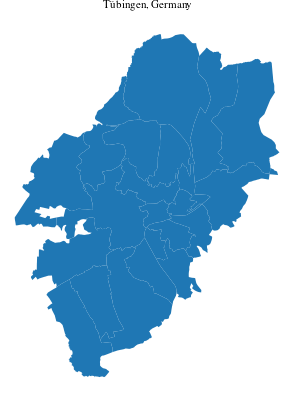

In [67]:
tuebingen_gdf.plot()
plt.title('Tübingen, Germany')
plt.axis("off")
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


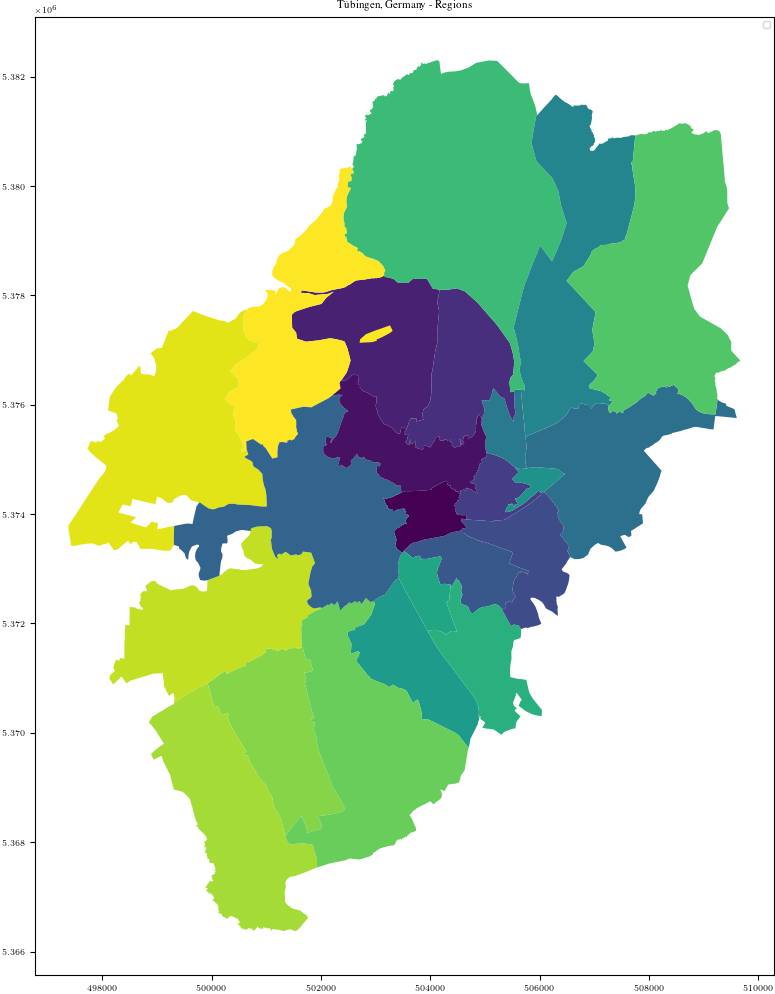

In [68]:
import geopandas as gpd
import matplotlib.pyplot as plt

tuebingen_gdf = gpd.read_file(path_tue_shp)

fig, ax = plt.subplots(figsize=(10, 10))

tuebingen_gdf.plot(ax=ax, cmap='viridis', edgecolor=None, legend=True, column='STT')

plt.title('Tübingen, Germany - Regions')
plt.legend()

plt.show()


### Issue we faced
We have no labels in the polygons, which makes it hard to identify the regions

#### Solution: Assign random labels to see which polygon corresponds to which region

['a6', '78', 'ru', 'zb', 'ld', '9v', 'mx', 'v2', 'zu', 'eu', 'tj', 'sh', 'ni', 'ew', 'j5', 't1', '5j', '7e', 'zw', 'ef', '9h', '74', 'uz']


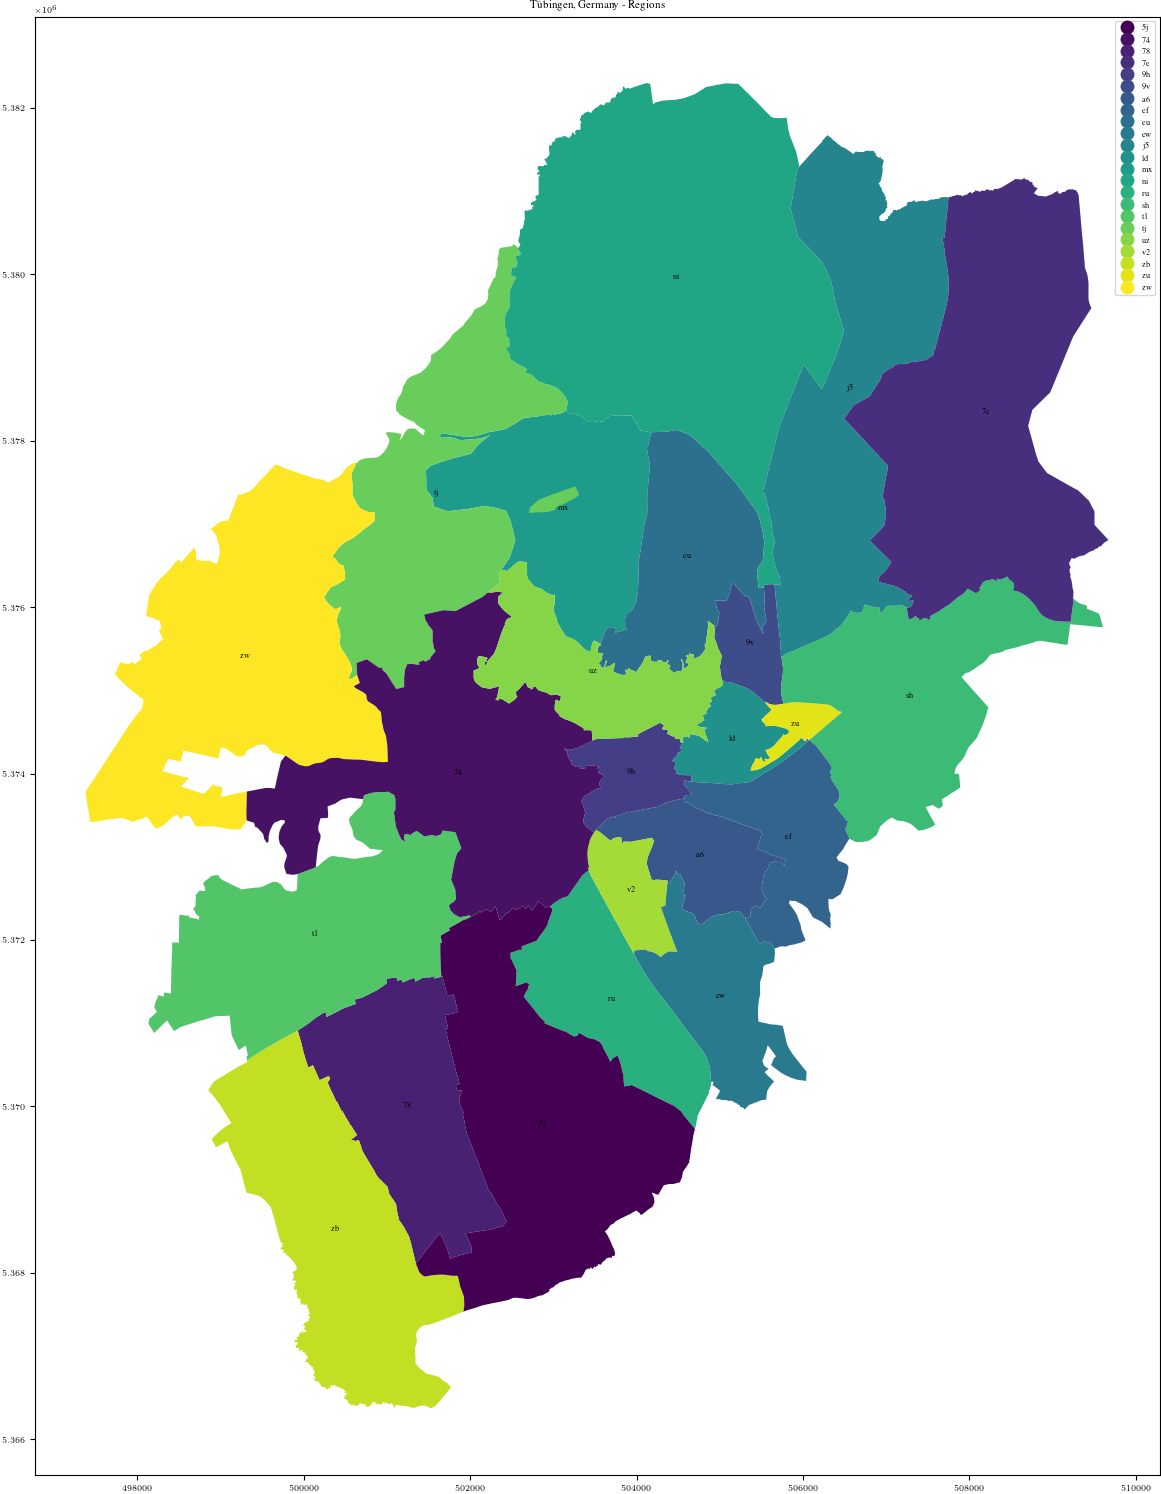

In [69]:
from random import choice
from string import ascii_lowercase, digits

chars = ascii_lowercase + digits
lst = [''.join(choice(chars) for _ in range(2)) for _ in range(23)]
print(lst)
import geopandas as gpd
import matplotlib.pyplot as plt

tuebingen_gdf = gpd.read_file(path_tue_shp)
tuebingen_gdf["region"] = lst
fig, ax = plt.subplots(figsize=(20, 15))


tuebingen_gdf.plot(ax=ax, cmap='viridis', edgecolor=None, legend=True,  column="region",)
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')


plt.title('Tübingen, Germany - Regions')

plt.show()


## Map regions now with OADR-U2

In [70]:
shp_dict = {'Universität':22,
 'Schönblick/Waldhäuser Ost':9,
 'Zentrum':20,
 'Bühl': 3,
 'Südstadt': 0,
 'Hagelloch': 10,
 'Kilchberg': 1,
 'Au/Unterer Wert/Französiches Viertel':19,
 'Weststadt':21,
 'Bebenhausen':12,
 'Hirschau':15,
 'Österberg/Gartenstraße':4,
 'Pfrondorf':17,
 'Wanne': 6,
 'Unterjesingen':18,
 'Feuerhägle/Mühlenviertel':7,
 'Lustnau-Zentrum/Herrlesberg/Stäudach':11,
 'De-Zentrum': 2,
 'Aeule':8,
 'Weilheim':16,
 'Denzenberg/Sand': 5,
 'Gartenstadt':13,
 'Neuhalde':14 }
sorted_dict = dict(sorted(shp_dict.items(), key=lambda item: item[1]))
sorted_dict

{'Südstadt': 0,
 'Kilchberg': 1,
 'De-Zentrum': 2,
 'Bühl': 3,
 'Österberg/Gartenstraße': 4,
 'Denzenberg/Sand': 5,
 'Wanne': 6,
 'Feuerhägle/Mühlenviertel': 7,
 'Aeule': 8,
 'Schönblick/Waldhäuser Ost': 9,
 'Hagelloch': 10,
 'Lustnau-Zentrum/Herrlesberg/Stäudach': 11,
 'Bebenhausen': 12,
 'Gartenstadt': 13,
 'Neuhalde': 14,
 'Hirschau': 15,
 'Weilheim': 16,
 'Pfrondorf': 17,
 'Unterjesingen': 18,
 'Au/Unterer Wert/Französiches Viertel': 19,
 'Zentrum': 20,
 'Weststadt': 21,
 'Universität': 22}

In [71]:
res = dict((v,k) for k,v in shp_dict.items()) 

In [72]:
df.groupby(['oadr_u1'])['oadr_u2'].apply(lambda grp: list(grp.value_counts().index)).to_dict() # could be useful maybe

{'Bebenhausen': ['Bebenhausen'],
 'Bühl': ['Bühl'],
 'Derendingen': ['Feuerhägle/Mühlenviertel', 'De-Zentrum', 'Gartenstadt'],
 'Hagelloch': ['Hagelloch'],
 'Hirschau': ['Hirschau'],
 'Kilchberg': ['Kilchberg'],
 'Lustnau': ['Lustnau-Zentrum/Herrlesberg/Stäudach',
  'Denzenberg/Sand',
  'Neuhalde',
  'Aeule'],
 'Pfrondorf': ['Pfrondorf'],
 'Tübingen': ['Universität',
  'Weststadt',
  'Südstadt',
  'Zentrum',
  'Schönblick/Waldhäuser Ost',
  'Wanne',
  'Au/Unterer Wert/Französiches Viertel',
  'Österberg/Gartenstraße'],
 'Unterjesingen': ['Unterjesingen'],
 'Weilheim': ['Weilheim']}

### Plot the map with the right regions

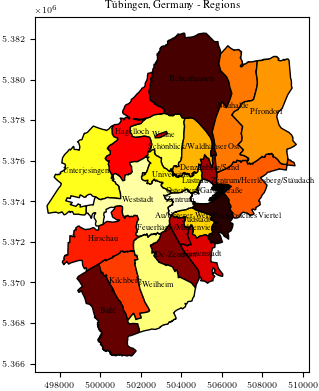

In [73]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf = gpd.read_file(path_tue_shp)
tuebingen_gdf["region"] = sorted_dict.keys()

# Create a larger plot with a specified size
fig, ax = plt.subplots()

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf.plot(ax=ax, cmap='hot', edgecolor='black', column="region",)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions')

# Show the plot
plt.show()


### Generate random column with value representing the density and plot it

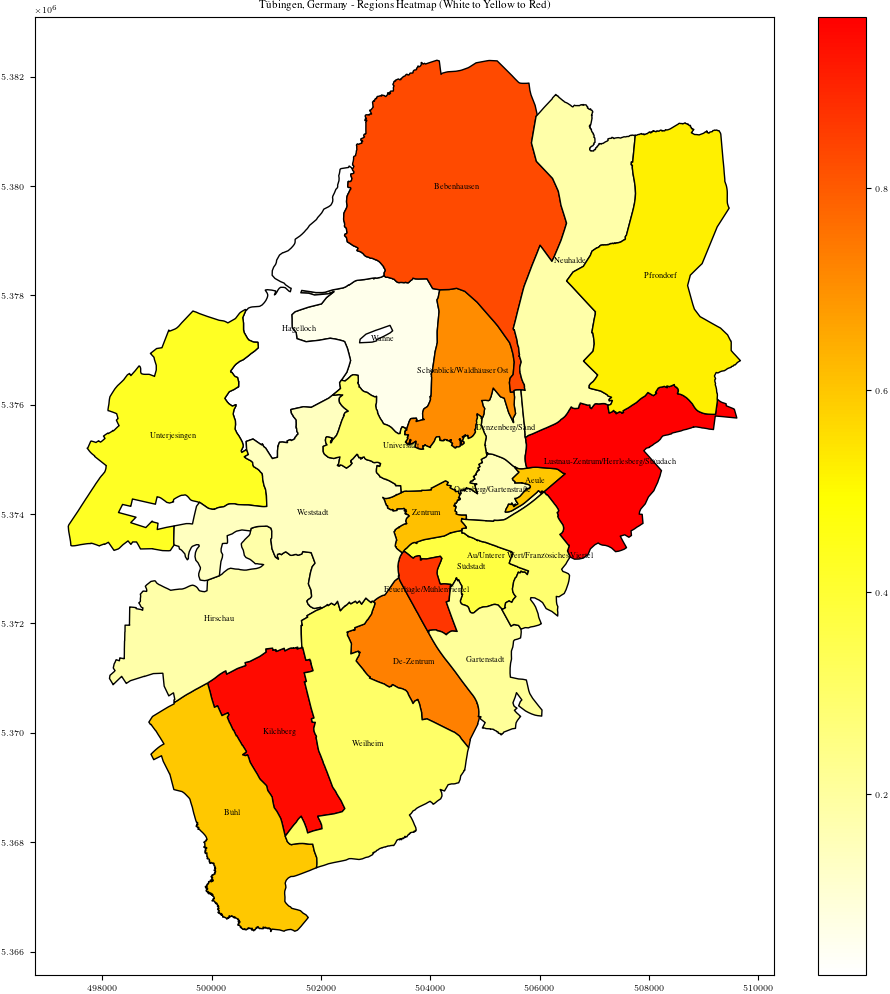

In [74]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

tuebingen_gdf = gpd.read_file(path_tue_shp)

np.random.seed(42) 
tuebingen_gdf["density"] = np.random.rand(len(tuebingen_gdf))
tuebingen_gdf["region"] = sorted_dict.keys()
colors = [(1, 1, 1), (1, 1, 0), (1, 0, 0)]  
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

fig, ax = plt.subplots(figsize=(10, 10))

tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="density", legend=True)

for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

plt.title('Tübingen, Germany - Regions Heatmap (White to Yellow to Red)')

plt.show()


# Density plot
## The more flats in one area, the darker the color

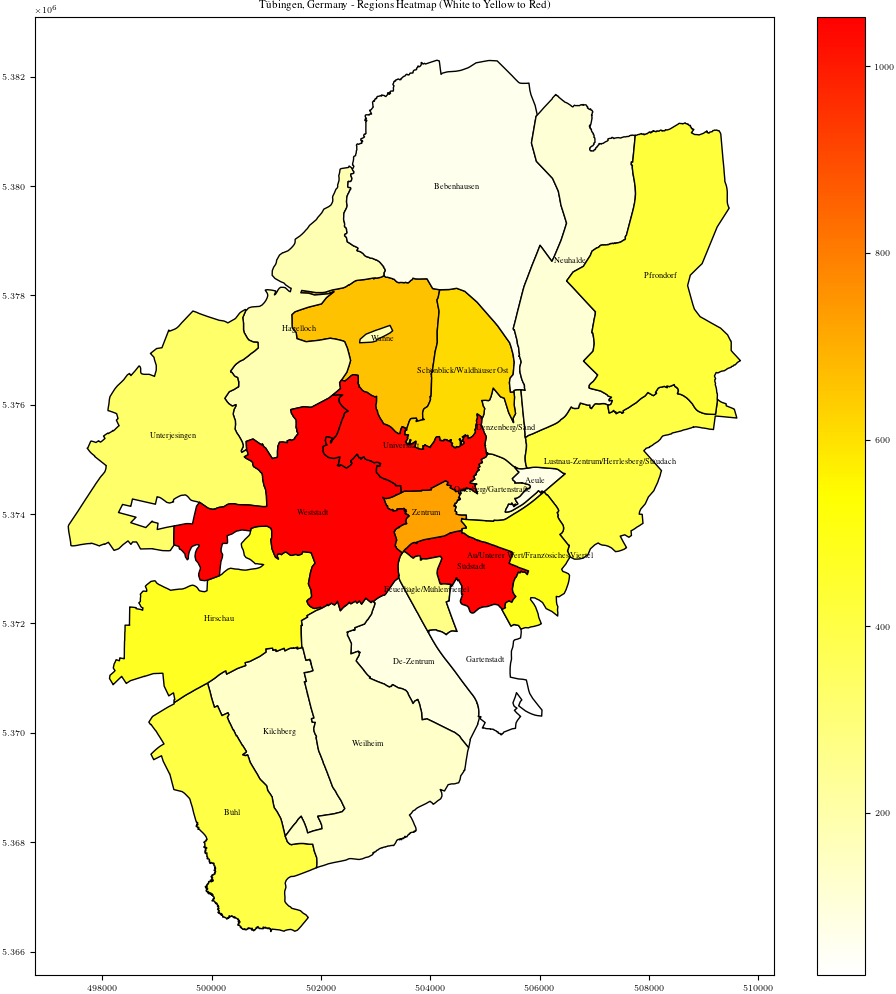

In [75]:
df_grouped = df_w_loc.groupby(["oadr_u2"]).size().reset_index(name='number_elements')
tuebingen_gdf = gpd.read_file(path_tue_shp)
tuebingen_gdf["region"] = sorted_dict.keys()
tuebingen_gdf = tuebingen_gdf.join(df_grouped.set_index("oadr_u2"), on="region")
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

fig, ax = plt.subplots(figsize=(10, 10))

tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="number_elements", legend=True)

for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

plt.title('Tübingen, Germany - Regions Heatmap (White to Yellow to Red)')

plt.show()



## ToDo Now

- [ ] Heatmap to usefull test statistics, like median or average rent
- [ ] maybe beautify heatmap aswell
- [ ] also maybe take ration into account, [Bevölkerung](https://www.tuebingen.de/Dateien/einwohner_stadtteile_Jahresvergleich.pdf) 


In [27]:
df_miete = df_w_loc[df_w_loc["nachfrageart"] == "miete"].groupby(["oadr_u2"]).size().reset_index(name='count_miete')

In [29]:
tuebingen_gdf = tuebingen_gdf.join(df_miete.set_index("oadr_u2"), on="region")

In [30]:
tuebingen_gdf["count_miete_normalized"] = tuebingen_gdf["count_miete"] / tuebingen_gdf["count_miete"].max()

In [76]:
# Kaufeinträge
df_w_loc.groupby(["oadr_u2", "nachfrageart"]).size().reset_index(name='count')

oadr_u2 nachfrageart  count
0                                  Aeule         kauf     26
1                                  Aeule        miete     50
2   Au/Unterer Wert/Französiches Viertel         kauf     90
3   Au/Unterer Wert/Französiches Viertel        miete    391
4                            Bebenhausen         kauf     19
5                            Bebenhausen        miete     44
6                                   Bühl         kauf    176
7                                   Bühl        miete    227
8                             De-Zentrum         kauf     20
9                             De-Zentrum        miete     70
10                       Denzenberg/Sand         kauf     45
11                       Denzenberg/Sand        miete    146
12              Feuerhägle/Mühlenviertel         kauf     55
13              Feuerhägle/Mühlenviertel        miete    214
14                           Gartenstadt         kauf      8
15                           Gartenstadt        miete     18
16                             Hagelloch         kauf     45
17                             Hagelloch        miete    137
18                              Hirschau         kauf    158
19                              Hirschau        miete    314
20                             Kilchberg         kauf     61
21                             Kilchberg        miete     77
22  Lustnau-Zentrum/Herrlesberg/Stäudach         kauf     62
23  Lustnau-Zentrum/Herrlesberg/Stäudach        miete    341
24                              Neuhalde         kauf     21
25                              Neuhalde        miete     90
26                             Pfrondorf         kauf    112
27                             Pfrondorf        miete    308
28             Schönblick/Waldhäuser Ost         kauf    139
29             Schönblick/Waldhäuser Ost        miete    475
30                              Südstadt         kauf    346
31                              Südstadt        miete    701
32                           Universität         kauf    186
33                           Universität        miete    844
34                         Unterjesingen         kauf    116
35                         Unterjesingen        miete    213
36                                 Wanne         kauf    208
37                                 Wanne        miete    453
38                              Weilheim         kauf     54
39                              Weilheim        miete     84
40                             Weststadt         kauf    319
41                             Weststadt        miete    734
42                               Zentrum         kauf    199
43                               Zentrum        miete    528
44                Österberg/Gartenstraße         kauf     47
45                Österberg/Gartenstraße        miete    160

In [77]:
df_kauf = df_w_loc[df_w_loc["nachfrageart"] == "kauf"].groupby(["oadr_u2"]).size().reset_index(name='count_kauf')
df_miete = df_w_loc[df_w_loc["nachfrageart"] == "miete"].groupby(["oadr_u2"]).size().reset_index(name='count_miete')

In [78]:
df_kauf

oadr_u2  count_kauf
0                                  Aeule          26
1   Au/Unterer Wert/Französiches Viertel          90
2                            Bebenhausen          19
3                                   Bühl         176
4                             De-Zentrum          20
5                        Denzenberg/Sand          45
6               Feuerhägle/Mühlenviertel          55
7                            Gartenstadt           8
8                              Hagelloch          45
9                               Hirschau         158
10                             Kilchberg          61
11  Lustnau-Zentrum/Herrlesberg/Stäudach          62
12                              Neuhalde          21
13                             Pfrondorf         112
14             Schönblick/Waldhäuser Ost         139
15                              Südstadt         346
16                           Universität         186
17                         Unterjesingen         116
18                                 Wanne         208
19                              Weilheim          54
20                             Weststadt         319
21                               Zentrum         199
22                Österberg/Gartenstraße          47

In [79]:
tuebingen_gdf = tuebingen_gdf.join(df_kauf.set_index("oadr_u2"), on="region")
tuebingen_gdf = tuebingen_gdf.join(df_miete.set_index("oadr_u2"), on="region")

In [80]:
# normalize
tuebingen_gdf["count_miete_normalized"] = tuebingen_gdf["count_miete"] / tuebingen_gdf["count_miete"].max()
tuebingen_gdf["count_kauf_normalized"] = tuebingen_gdf["count_kauf"] / tuebingen_gdf["count_miete"].max()


In [81]:
tuebingen_gdf

STT                                           geometry  \
0   017  POLYGON ((503797.299 5373237.931, 503796.260 5...   
1   141  POLYGON ((501347.373 5368108.085, 501347.345 5...   
2   031  POLYGON ((502556.148 5371633.120, 502555.725 5...   
3   151  POLYGON ((501081.664 5366361.284, 501081.604 5...   
4   015  POLYGON ((505153.410 5373868.879, 505153.094 5...   
5   022  POLYGON ((505736.190 5375415.014, 505736.419 5...   
6   013  POLYGON ((503751.717 5375735.066, 503751.565 5...   
7   032  POLYGON ((503629.452 5373238.842, 503629.655 5...   
8   026  POLYGON ((505417.314 5374039.556, 505415.652 5...   
9   014  POLYGON ((504850.099 5375727.705, 504849.562 5...   
10  181  MULTIPOLYGON (((501111.618 5375015.467, 501111...   
11  021  POLYGON ((505808.921 5375444.449, 505809.473 5...   
12  111  POLYGON ((505720.442 5376361.552, 505720.491 5...   
13  033  POLYGON ((503973.198 5371867.502, 503973.327 5...   
14  023  POLYGON ((505807.235 5375444.120, 505806.743 5...   
15  161  POLYGON ((500832.140 5373770.503, 500835.105 5...   
16  131  POLYGON ((502952.928 5367787.442, 502952.844 5...   
17  121  POLYGON ((509216.716 5375824.085, 509216.638 5...   
18  171  POLYGON ((500990.391 5374435.215, 500990.784 5...   
19  016  POLYGON ((506430.426 5373696.343, 506429.692 5...   
20  011  POLYGON ((504379.519 5374517.962, 504380.897 5...   
21  018  POLYGON ((503151.740 5374647.792, 503154.014 5...   
22  012  POLYGON ((504834.553 5375610.953, 504834.554 5...   

                                  region  number_elements  count_miete  \
0                               Südstadt              667          667   
1                              Kilchberg               67           67   
2                             De-Zentrum               68           68   
3                                   Bühl              208          208   
4                 Österberg/Gartenstraße              149          149   
5                        Denzenberg/Sand              143          143   
6                                  Wanne              429          429   
7               Feuerhägle/Mühlenviertel              211          211   
8                                  Aeule               48           48   
9              Schönblick/Waldhäuser Ost              463          463   
10                             Hagelloch              124          124   
11  Lustnau-Zentrum/Herrlesberg/Stäudach              327          327   
12                           Bebenhausen               40           40   
13                           Gartenstadt               15           15   
14                              Neuhalde               84           84   
15                              Hirschau              288          288   
16                              Weilheim               69           69   
17                             Pfrondorf              276          276   
18                         Unterjesingen              192          192   
19  Au/Unterer Wert/Französiches Viertel              386          386   
20                               Zentrum              510          510   
21                             Weststadt              714          714   
22                           Universität              822          822   

    count_miete_normalized  
0                 0.811436  
1                 0.081509  
2                 0.082725  
3                 0.253041  
4                 0.181265  
5                 0.173966  
6                 0.521898  
7                 0.256691  
8                 0.058394  
9                 0.563260  
10                0.150852  
11                0.397810  
12                0.048662  
13                0.018248  
14                0.102190  
15                0.350365  
16                0.083942  
17                0.335766  
18                0.233577  
19                0.469586  
20                0.620438  
21                0.868613  
22                1.000000

count_miete    844
dtype: int64


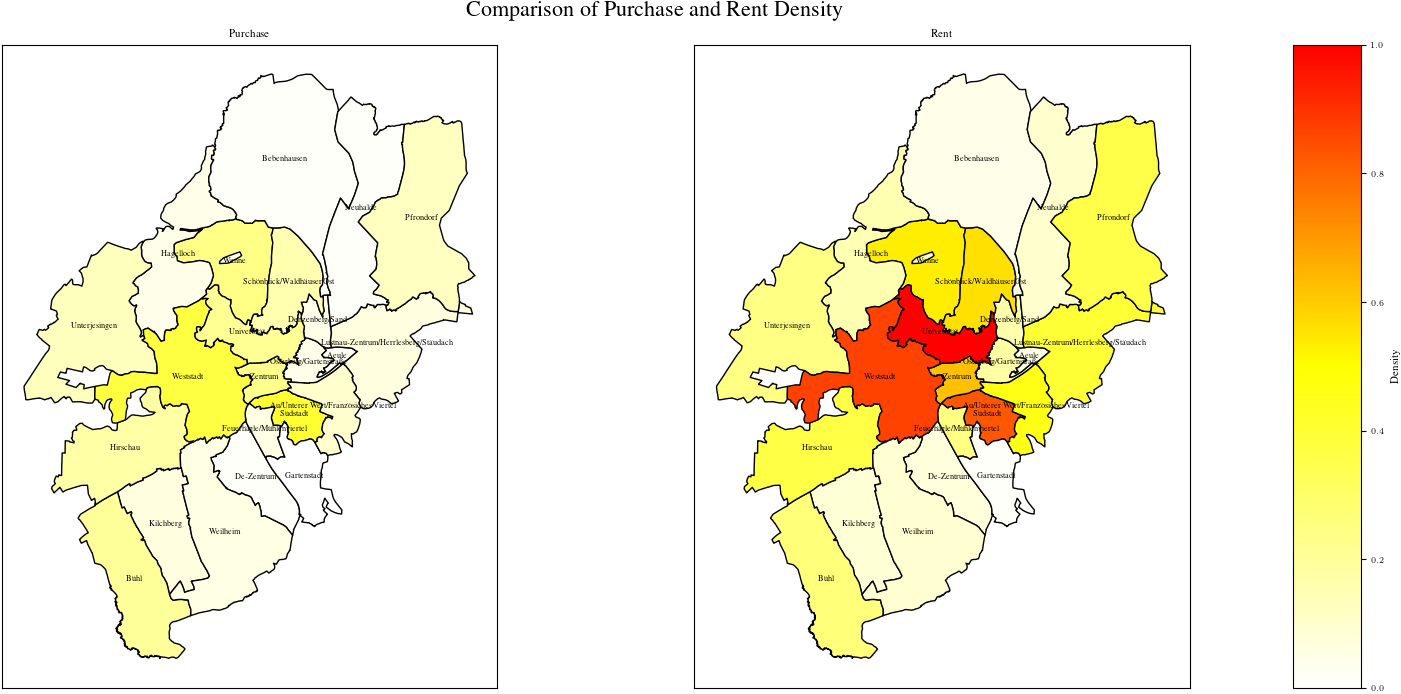

In [82]:
# https://stackoverflow.com/questions/44707213/generating-multiple-heatmaps-with-the-same-gradient

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

fig, axs = plt.subplots(1, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [10, 10, 1]})

# Plot the GeoDataFrame with heatmaps based on density values using the custom colormap
vmax = tuebingen_gdf[["count_miete"]].max()
vmin = tuebingen_gdf[["count_kauf"]].min()
print(vmax)
for ax, density_column, title in zip(axs[:-1], ["count_kauf", "count_miete"], ["Purchase", "Rent"]):
    tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column=density_column, legend=False, vmin=vmin, vmax=vmax) # vmin und vmax machen magic, check nach ob stimmt
    ax.set_title(title)
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])

# Add labels and legend
cax = axs[-1]
sm = plt.cm.ScalarMappable(cmap=cmap_white_yellow_red)
sm.set_array([])  # You need to set an array even if empty
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Density')

for ax, density_column in zip(axs[:-1], ["count_kauf", "count_miete"]):
    for idx, row in tuebingen_gdf.iterrows():
        ax.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Set overall title
fig.suptitle('Comparison of Purchase and Rent Density', fontsize=16)

# Adjust layout to prevent clipping of titles


# Show th



# Show the plot
plt.show()



--------------

# Bearbeitete Plots

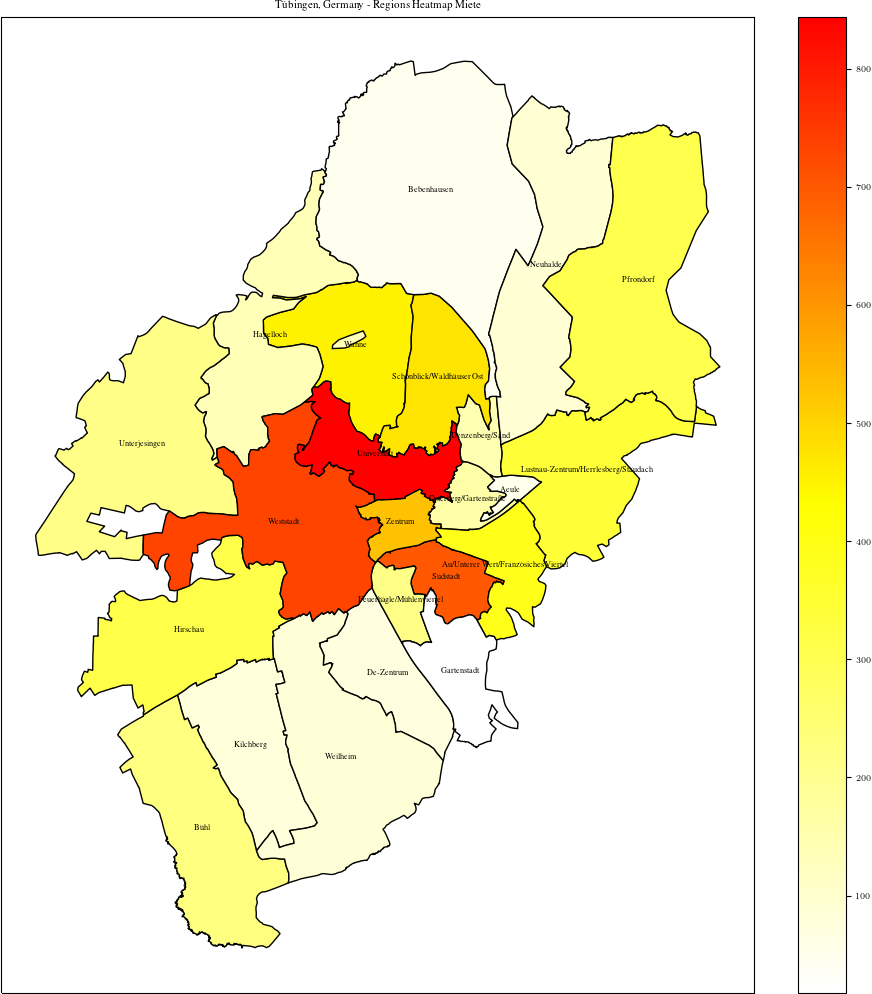

In [83]:
# rent
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="count_miete", legend=True)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions Heatmap Miete')

# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
# Show the plot
plt.show()



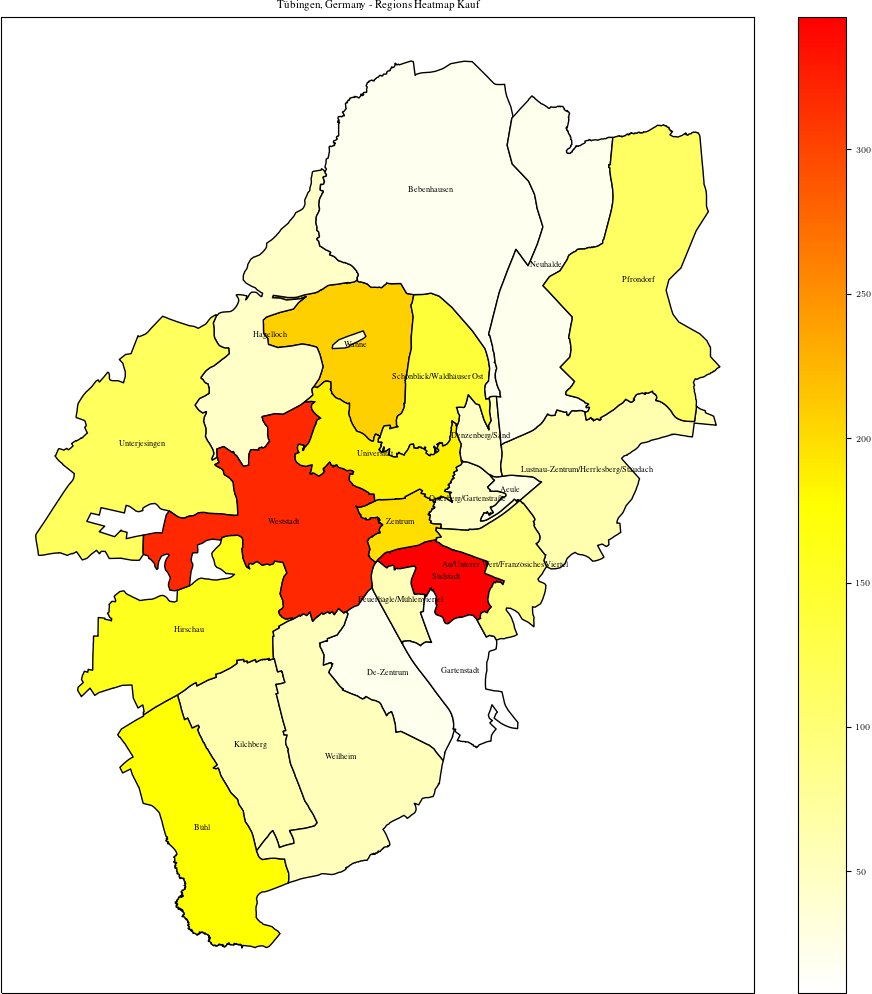

In [84]:

cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="count_kauf", legend=True)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions Heatmap Kauf')
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
# Show the plot
plt.show()



In [113]:
df

anz_zimmer  aus_kueche_einbau_janein  aus_pool_janein  baujahr  \
16004         4.0                         1                0      0.0   
15991         3.0                         1                0   2001.0   
15992         3.0                         0                0   1962.0   
15993         5.5                         1                0   1966.0   
15995         4.0                         0                0   1962.0   
...           ...                       ...              ...      ...   
34            4.0                         0                0   2025.0   
33            3.0                         0                0   2025.0   
32            3.0                         0                0   2025.0   
45            1.0                         0                0   1991.0   
1             2.0                         1                0   1980.0   

       flaeche  kstn_miete_kalt_pqm  aus_heiz_system_0  aus_heiz_system_Etage  \
16004    87.00                 7.24              False                  False   
15991    71.59                 0.00              False                  False   
15992    75.00                 0.00              False                  False   
15993   125.00                 9.68              False                  False   
15995    92.00                 0.00              False                  False   
...        ...                  ...                ...                    ...   
34       96.36                 0.00              False                  False   
33       67.66                 0.00              False                  False   
32       67.67                 0.00              False                  False   
45       30.00                19.00               True                  False   
1        50.00                15.00               True                  False   

       aus_heiz_system_Zentral  aus_heiz_system_Zimmer  
16004                     True                   False  
15991                     True                   False  
15992                     True                   False  
15993                     True                   False  
15995                     True                   False  
...                        ...                     ...  
34                        True                   False  
33                        True                   False  
32                        True                   False  
45                       False                   False  
1                        False                   False  

[11927 rows x 10 columns]

In [117]:

grouped_df = df.groupby("oadr_u2")["baujahr"].agg(["mean", lambda x: x.max() - x.min()])

# Reset index to make "oadr_u2" a column again
grouped_df.reset_index(inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(grouped_df["oadr_u2"], grouped_df["mean"], yerr=grouped_df["<lambda>"], capsize=5, color='lightblue', edgecolor='black')

# Set labels and title
plt.xlabel("Area (oadr_u2)")
plt.ylabel("Construction Time (baujahr)")
plt.title("Construction Time vs. Area")

# Show the plot
plt.show()

KeyError: '<lambda>'

<Figure size 1000x600 with 0 Axes>

# ToDo
Mach die in ein Plot, nutz vllt andere Farben

In [85]:
short_labels = {
    'Südstadt': 'Sdst',
    'Kilchberg': 'Klb',
    'De-Zentrum': 'DZtrm',
    'Bühl': 'Bhl',
    'Österberg/Gartenstraße': 'Ost/Gstr',
    'Denzenberg/Sand': 'Dzb/Snd',
    'Wanne': 'Wn',
    'Feuerhägle/Mühlenviertel': 'Fhgl/Mvrtl',
    'Aeule': 'Ae',
    'Schönblick/Waldhäuser Ost': 'Sbl/Wo',
    'Hagelloch': 'Hgl',
    'Lustnau-Zentrum/Herrlesberg/Stäudach': 'Lnz/Hst',
    'Bebenhausen': 'Bbh',
    'Gartenstadt': 'Gstdt',
    'Neuhalde': 'Nhd',
    'Hirschau': 'Hrsch',
    'Weilheim': 'Wlm',
    'Pfrondorf': 'Pfrd',
    'Unterjesingen': 'Ujsg',
    'Au/Unterer Wert/Französiches Viertel': 'Au/Uw/Fv',
    'Zentrum': 'Ztrm',
    'Weststadt': 'Wstd',
    'Universität': 'Univ'
}


/tmp/ipykernel_2240955/3547432302.py:42: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=0.8)  # Adjust this as needed


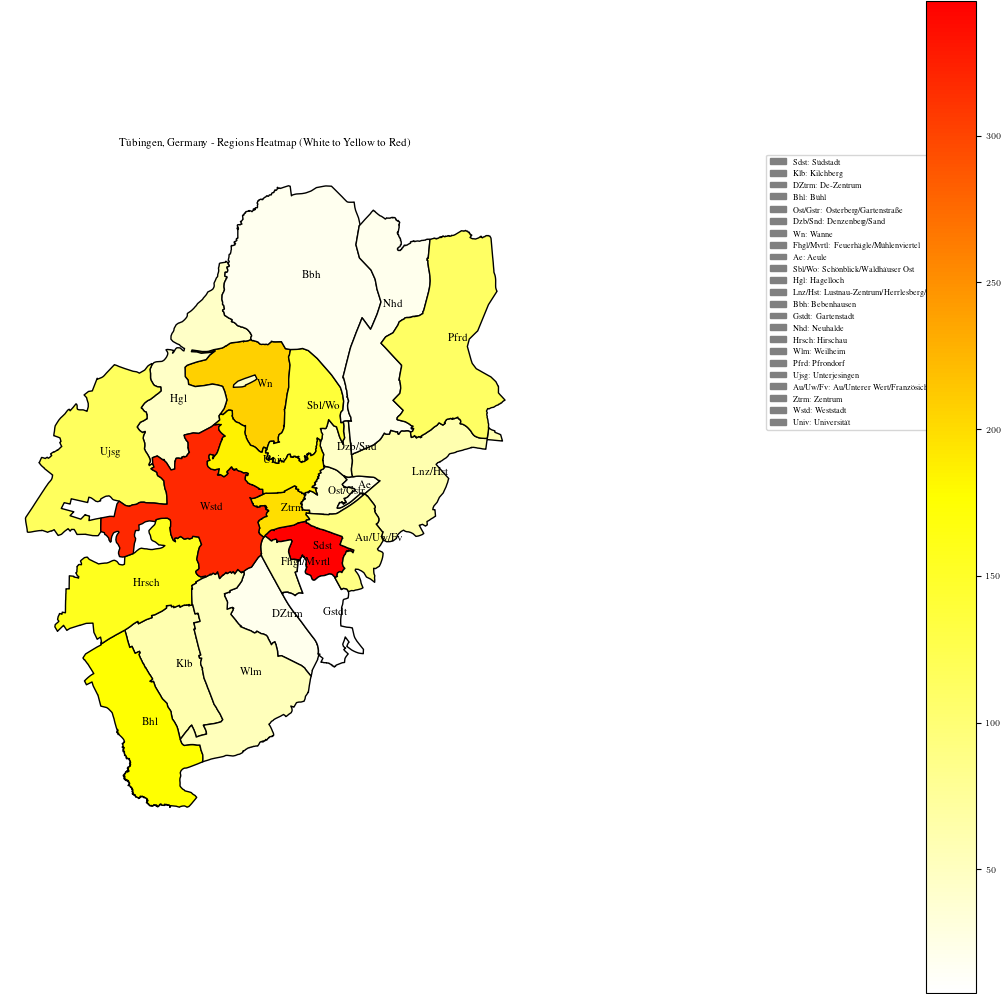

In [86]:

# purchase
from matplotlib.patches import Polygon
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="count_kauf", legend=True)

# Add shortened labels for each region
for idx, row in tuebingen_gdf.iterrows():
    short_label = short_labels.get(row["region"], row["region"])  # Use the short label if available
    x,y = row["geometry"].centroid.coords[0]
    if row["region"] == "Wanne":
        x,y= x+200.0105, y-0.0005
    if row["region"] == "Hagelloch":
        x,y= x-500.0105, y-600.0005
    if row["region"] == "Neuhalde":
        x,y= x-2, y+600.0005
    plt.annotate(short_label, xy=(x,y), fontsize=8, color='black')




plt.title('Tübingen, Germany - Regions Heatmap (White to Yellow to Red)')

ax.set_axis_off()
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


ax.set_axis_off()

# Now we will create the legend for the short labels manually.
# We create a list of patches for the legend
legend_patches = [mpatches.Patch(color='grey', label=f'{short}: {region}') for region, short in short_labels.items()]


# Add the building marker to your list of legend patches

plt.legend(handles=legend_patches,bbox_to_anchor=(1.45, 1), loc=2, borderaxespad=0.)


plt.subplots_adjust(right=0.8)  # Adjust this as needed

# Show the plot
plt.show()



plt.show()


### Noch zu tuen
- Die Legende vielleicht farblich wie das polygon ?
- Oder zumindest aufsteigend bzw absteigend sortieren, man schaut intuitiv immer bei roten eher oben in der Liste
- hätte effekt das wir direkt noch sehen was oben und unten ist

### Getan
- purchase und miete mal getrennt in seperate plots
- die müssen wir nur noch jetzt in eine figure
- hab kürzel hinzugefügt
- kann jetzt die labels in den polygon plot direkt adressieren, zumindest die position 


# Take population into account

## Nutze den Link von oben für Bevölkerung

In [87]:
data = {
    "region": [
        "Zentrum", "Universität", "Wanne", "Schönblick/Waldhäuser Ost",
        "Österberg/Gartenstraße", "Au/Unterer Wert/Französiches Viertel",
        "Südstadt", "Weststadt", "Lustnau-Zentrum/Herrlesberg/Stäudach",
        "Denzenberg/Sand", "Neuhalde", "Aeule", "De-Zentrum",
        "Feuerhägle/Mühlenviertel", "Gartenstadt", "Bebenhausen",
        "Pfrondorf", "Weilheim", "Kilchberg", "Bühl", "Hirschau",
        "Unterjesingen", "Hagelloch", "Gesamt"
    ],
    "2016": [
        6430, 8242, 5384, 9779, 2509, 3656, 10459, 8519, 5908,
        2421, 1261, 985, 1863, 4484, 494, 343, 3343, 1498, 1252,
        2114, 3289, 2580, 1713, 88526
    ],
    "2017": [
        6503, 8299, 5370, 9878, 2580, 3832, 10484, 8622, 5950,
        2438, 1287, 988, 1860, 4857, 496, 328, 3360, 1468, 1271,
        2125, 3288, 2624, 1702, 89610
    ],
    "2018": [
        6479, 8524, 5359, 9838, 2580, 4248, 10518, 8687, 5957,
        2479, 1318, 995, 1888, 5191, 473, 338, 3363, 1445, 1299,
        2145, 3304, 2627, 1709, 90764
    ],
    "2019": [
        6516, 8618, 5528, 9968, 2632, 4678, 10618, 8778, 6037,
        2499, 1315, 984, 1846, 5110, 473, 326, 3348, 1467, 1295,
        2172, 3276, 2640, 1715, 91839
    ],
    "2020": [
        6371, 8445, 5469, 9772, 2685, 4997, 10519, 8607, 5910,
        2550, 1320, 977, 1810, 4806, 463, 333, 3319, 1446, 1287,
        2154, 3297, 2627, 1713, 90877
    ],
    "2021": [
        6501, 8593, 5541, 9959, 2708, 5291, 10578, 8708, 5930,
        2605, 1300, 958, 1789, 5061, 457, 336, 3315, 1443, 1274,
        2171, 3359, 2566, 1727, 92170
    ],
    "2022": [
        6540, 8568, 5665, 10004, 2707, 5272, 10616, 8828, 5952,
        2586, 1287, 1033, 1780, 5206, 459, 322, 3348, 1475, 1266,
        2182, 3384, 2567, 1753, 92800
    ]
}

# Erstellen des DataFrames
df_people = pd.DataFrame(data)
df_people = df_people.set_index("region")

print(df)


        angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
13      3600335162         1.0         2.0                       0   
25      3600015008         NaN         2.0                       0   
34      3600573075         1.0         1.0                       0   
36      3600507111         NaN         2.5                       0   
55      3600435949         NaN         2.0                       0   
...            ...         ...         ...                     ...   
106694    60855988         NaN         2.0                       0   
106702    40569012         NaN         5.0                       0   
106705    27424499         1.0         2.0                       0   
106717  3041045247         NaN         2.5                       0   
106718  3040210896         NaN         4.0                       0   

        aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
13                          0                        0   
25                          1              

### Calculate average per population per region, aint no much difference between the years, I guess its legit to do that

In [88]:
# calculate mean from 2016 to 2022
mean_pop = df_people.mean(axis=1).round(0).astype(int)
mean_pop

region
Zentrum                                  6477
Universität                              8470
Wanne                                    5474
Schönblick/Waldhäuser Ost                9885
Österberg/Gartenstraße                   2629
Au/Unterer Wert/Französiches Viertel     4568
Südstadt                                10542
Weststadt                                8678
Lustnau-Zentrum/Herrlesberg/Stäudach     5949
Denzenberg/Sand                          2511
Neuhalde                                 1298
Aeule                                     989
De-Zentrum                               1834
Feuerhägle/Mühlenviertel                 4959
Gartenstadt                               474
Bebenhausen                               332
Pfrondorf                                3342
Weilheim                                 1463
Kilchberg                                1278
Bühl                                     2152
Hirschau                                 3314
Unterjesingen              

### merge them

In [89]:
tuebingen_gdf = tuebingen_gdf.join(mean_pop.rename("population"), on="region")

tuebingen_gdf

STT                                           geometry  \
0   017  POLYGON ((503797.299 5373237.931, 503796.260 5...   
1   141  POLYGON ((501347.373 5368108.085, 501347.345 5...   
2   031  POLYGON ((502556.148 5371633.120, 502555.725 5...   
3   151  POLYGON ((501081.664 5366361.284, 501081.604 5...   
4   015  POLYGON ((505153.410 5373868.879, 505153.094 5...   
5   022  POLYGON ((505736.190 5375415.014, 505736.419 5...   
6   013  POLYGON ((503751.717 5375735.066, 503751.565 5...   
7   032  POLYGON ((503629.452 5373238.842, 503629.655 5...   
8   026  POLYGON ((505417.314 5374039.556, 505415.652 5...   
9   014  POLYGON ((504850.099 5375727.705, 504849.562 5...   
10  181  MULTIPOLYGON (((501111.618 5375015.467, 501111...   
11  021  POLYGON ((505808.921 5375444.449, 505809.473 5...   
12  111  POLYGON ((505720.442 5376361.552, 505720.491 5...   
13  033  POLYGON ((503973.198 5371867.502, 503973.327 5...   
14  023  POLYGON ((505807.235 5375444.120, 505806.743 5...   
15  161  POLYGON ((500832.140 5373770.503, 500835.105 5...   
16  131  POLYGON ((502952.928 5367787.442, 502952.844 5...   
17  121  POLYGON ((509216.716 5375824.085, 509216.638 5...   
18  171  POLYGON ((500990.391 5374435.215, 500990.784 5...   
19  016  POLYGON ((506430.426 5373696.343, 506429.692 5...   
20  011  POLYGON ((504379.519 5374517.962, 504380.897 5...   
21  018  POLYGON ((503151.740 5374647.792, 503154.014 5...   
22  012  POLYGON ((504834.553 5375610.953, 504834.554 5...   

                                  region  number_elements  count_miete  \
0                               Südstadt              667          667   
1                              Kilchberg               67           67   
2                             De-Zentrum               68           68   
3                                   Bühl              208          208   
4                 Österberg/Gartenstraße              149          149   
5                        Denzenberg/Sand              143          143   
6                                  Wanne              429          429   
7               Feuerhägle/Mühlenviertel              211          211   
8                                  Aeule               48           48   
9              Schönblick/Waldhäuser Ost              463          463   
10                             Hagelloch              124          124   
11  Lustnau-Zentrum/Herrlesberg/Stäudach              327          327   
12                           Bebenhausen               40           40   
13                           Gartenstadt               15           15   
14                              Neuhalde               84           84   
15                              Hirschau              288          288   
16                              Weilheim               69           69   
17                             Pfrondorf              276          276   
18                         Unterjesingen              192          192   
19  Au/Unterer Wert/Französiches Viertel              386          386   
20                               Zentrum              510          510   
21                             Weststadt              714          714   
22                           Universität              822          822   

    count_miete_normalized  population  
0                 0.811436       10542  
1                 0.081509        1278  
2                 0.082725        1834  
3                 0.253041        2152  
4                 0.181265        2629  
5                 0.173966        2511  
6                 0.521898        5474  
7                 0.256691        4959  
8                 0.058394         989  
9                 0.563260        9885  
10                0.150852        1719  
11                0.397810        5949  
12                0.048662         332  
13                0.018248         474  
14                0.102190        1298  
15                0.350365        3314  
16                0.083942        1463  


In [90]:
tuebingen_gdf["ratio"] = tuebingen_gdf["number_elements"] / tuebingen_gdf["population"]

## Plot the ratio, number of flats divided by population

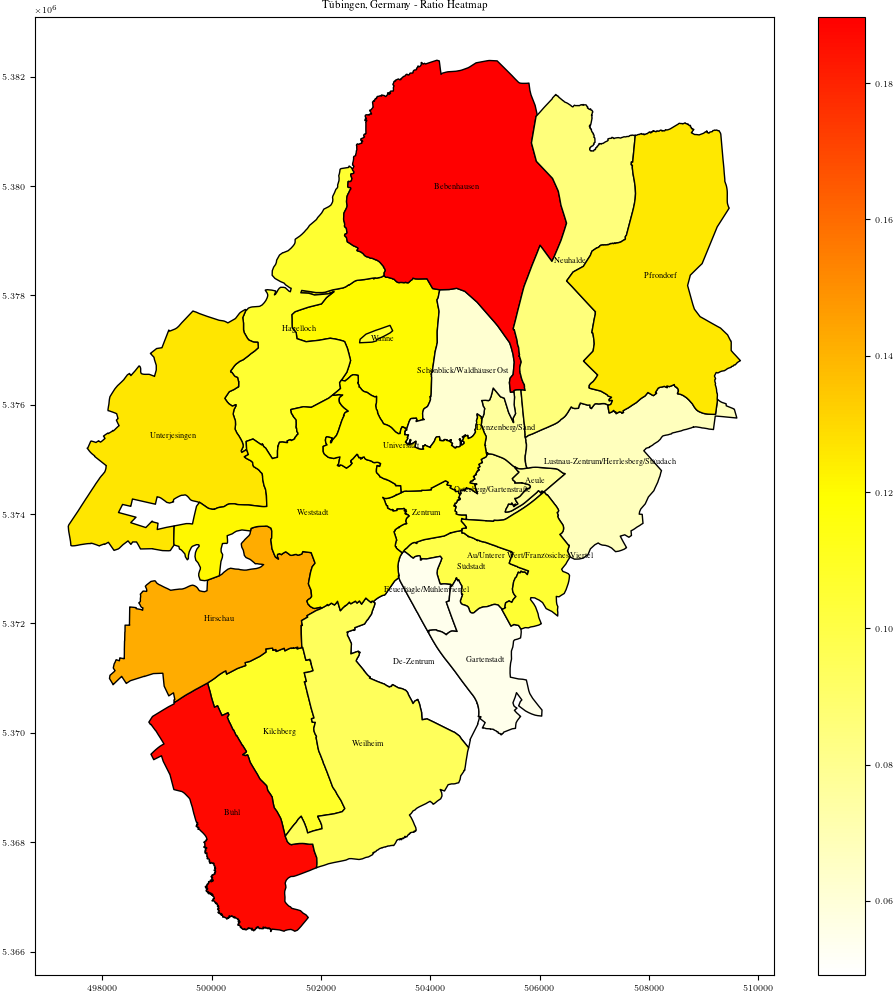

In [91]:
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="ratio", legend=True)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Ratio Heatmap')

# Show the plot
plt.show()



## Bringt uns das was ?

## Ausserdem
Wie alt sind die Regionen, im Sinne von Wohnungen und Häuser

## Potenzielle Erklärungsversuche, Spekulation ?

# Scatter plot und lineare Regression

Falls der approach nicht gut aussieht, müssen wir vielleicht auf polynomial regression umsteigen

In [92]:
interesting_regions = ["Zentrum", "Universität", "Wanne", "Schönblick/Waldhäuser Ost",]
df_w_loc

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
1      3594016393         NaN         2.0                       0   
2      3593975043         NaN         1.0                       0   
3      3594255459         1.0         3.0                       0   
4      3594061704         1.0         3.0                       0   
5      3593974527         2.0         2.5                       0   
...           ...         ...         ...                     ...   
15998    27439257         1.0         5.0                       0   
15999    27424499         1.0         2.0                       0   
16001    27375419         1.0         6.0                       0   
16002    27260230         1.0         6.0                       0   
16004  3040210896         NaN         4.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
1                          1                        0   
2                          0                        0   
3                          1                        1   
4                          0                        0   
5                          0                        0   
...                      ...                      ...   
15998                      1                        1   
15999                      1                        0   
16001                      1                        1   
16002                      1                        1   
16004                      0                        1   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
1                               0                     0   
2                               0                     0   
3                               0                     1   
4                               0                     1   
5                               0                     1   
...                           ...                   ...   
15998                           0                     1   
15999                           0                     1   
16001                           0                     0   
16002                           0                     0   
16004                           0                     1   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   
5                             0                          0   
...                         ...                        ...   
15998                         0                          0   
15999                         0                          0   
16001                         0                          0   
16002                         0                          0   
16004                         0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
5                               0                          0   
...                           ...                        ...   
15998                           0                          0   
15999                           0                          0   
16001                           0                          1   
16002                           0                          1   
16004                           0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
1                            0                 Gas   
2                            0                 NaN   
3                            0                 NaN   
4                            0                  Öl   


In [93]:
df_w_loc['year_month'] = df_w_loc['year'].astype(str) + '-' + df_w_loc['month'].astype(str).str.zfill(2)
df_w_loc = df_w_loc.sort_values(by=['year_month'])
df_w_loc

/tmp/ipykernel_2240955/103856554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc['year_month'] = df_w_loc['year'].astype(str) + '-' + df_w_loc['month'].astype(str).str.zfill(2)


angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
16004  3040210896         NaN         4.0                       0   
15991    58854993         1.0         3.0                       0   
15992    53677475         1.0         3.0                       0   
15993    44458486         2.0         5.5                       0   
15995    43152961         2.0         4.0                       0   
...           ...         ...         ...                     ...   
34     3592611553         1.0         4.0                       0   
33     3592611568         1.0         3.0                       0   
32     3592611656         1.0         3.0                       0   
45     3592318756         1.0         1.0                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
16004                      0                        1   
15991                      1                        0   
15992                      0                        0   
15993                      0                        1   
15995                      0                        0   
...                      ...                      ...   
34                         0                        0   
33                         0                        0   
32                         0                        0   
45                         0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
16004                           0                     1   
15991                           1                     1   
15992                           1                     1   
15993                           0                     1   
15995                           0                     1   
...                           ...                   ...   
34                              0                     0   
33                              0                     0   
32                              0                     0   
45                              0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
16004                         0                          0   
15991                         0                          0   
15992                         0                          0   
15993                         0                          0   
15995                         0                          0   
...                         ...                        ...   
34                            0                          0   
33                            0                          0   
32                            0                          0   
45                            0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
16004                           0                          0   
15991                           0                          0   
15992                           0                          0   
15993                           0                          0   
15995                           0                          0   
...                           ...                        ...   
34                              0                          0   
33                              0                          0   
32                              0                          0   
45                              0                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
16004                        0                  Öl   
15991                        0                 Gas   
15992                        0                 NaN   
15993                        0                  Öl   


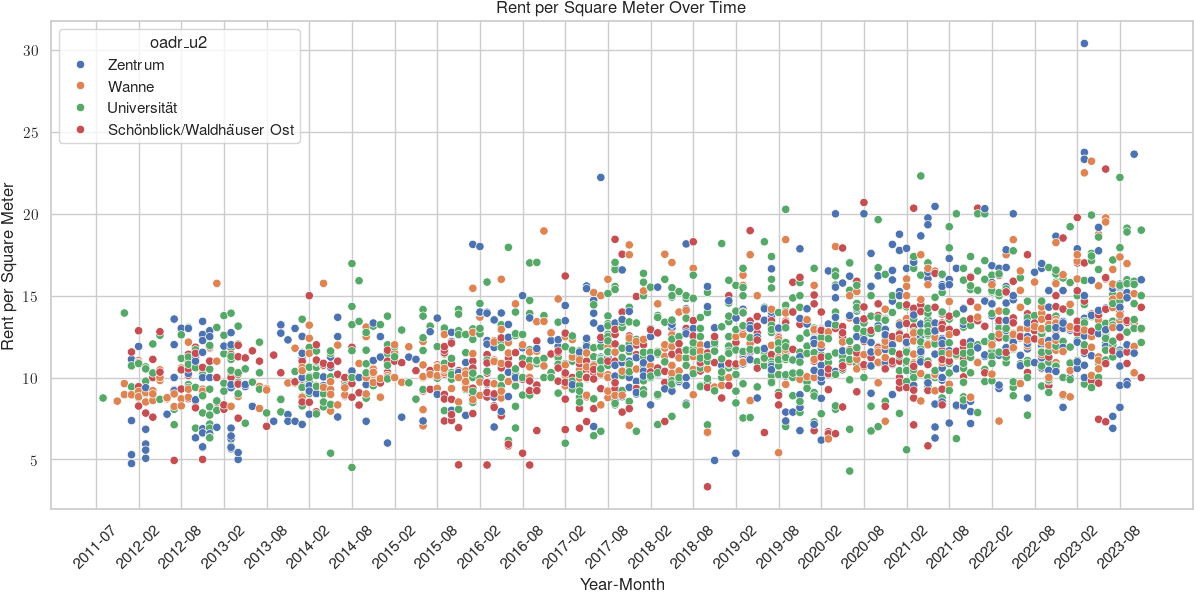

In [94]:
df_w_loc_interesting = df_w_loc[df_w_loc["oadr_u2"].isin(interesting_regions)]
# scatter plot with seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=df_w_loc_interesting, x="year_month", y="kstn_miete_kalt_pqm", hue="oadr_u2")
plt.title('Rent per Square Meter Over Time')
plt.xlabel('Year-Month')
plt.xticks(df_w_loc_interesting['year_month'].unique()[::6], rotation=45)
plt.ylabel('Rent per Square Meter')
plt.show()

/home/huber/master/ws23-24/data_literacy/DataLiteracy/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


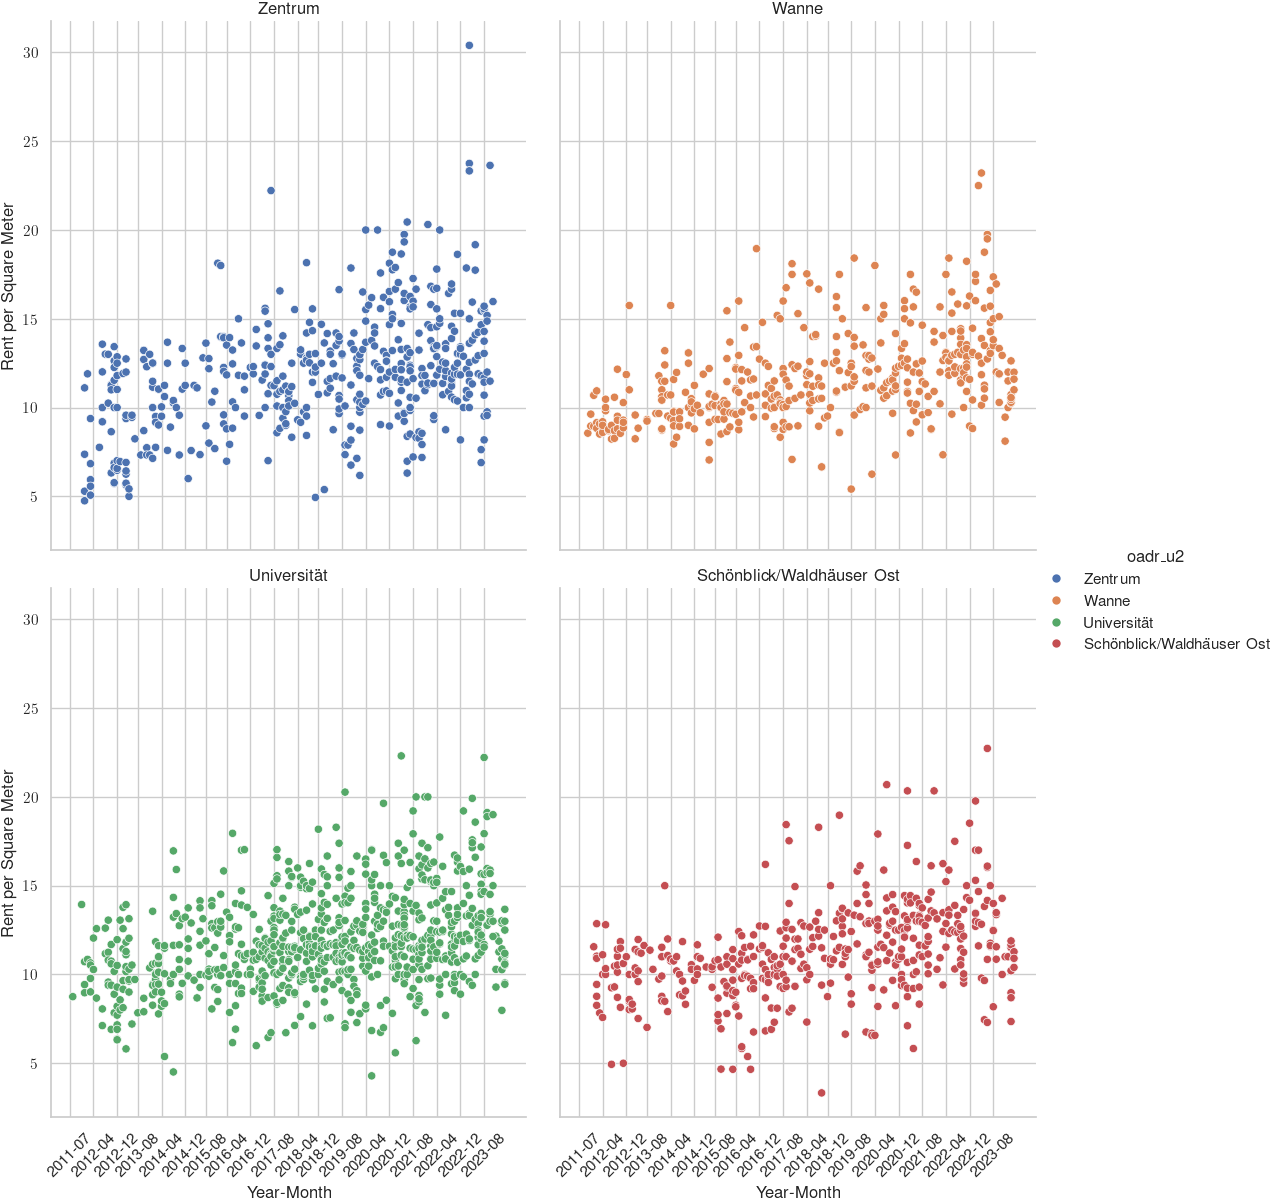

In [95]:
g = sns.relplot(
    data=df_w_loc_interesting,
    x="year_month", y="kstn_miete_kalt_pqm", col="oadr_u2",
    hue="oadr_u2",
    kind="scatter",
    height=6, aspect=0.9,  # Adjust height and aspect ratio to control the size,
    col_wrap=2
)

# Adjust the x-ticks rotation and interval
for ax in g.axes.flat:
    ax.set_xticks(df_w_loc_interesting['year_month'].unique()[::8])
    ax.set_xticklabels(df_w_loc_interesting['year_month'].unique()[::8], rotation=45)

# Adjust the title and labels
g.set_titles("{col_name}")
g.set_axis_labels("Year-Month", "Rent per Square Meter")

# Show the plot
plt.show()

## Linear regression
Weil wir als X-Werte das Datum haben, können wir nicht einfach linear regression anwenden. Wir gehen wie folgt vor:
1) Wir ändern unsere Werte zu ordinalen Werten
2) Splitten x und y
3) Fitten die Kurve
4) Ploten die Kurve in die scatter plots rein

### 1) Ordinal values

In [96]:
df_w_loc_interesting_copy = df_w_loc_interesting.copy()
df_w_loc_interesting_copy["startdate"]

15998    2011-07-23
15978    2011-08-09
15979    2011-08-09
15989    2011-08-02
15952    2011-09-17
            ...    
59       2023-11-02
50       2023-11-03
46       2023-11-03
45       2023-11-03
1        2023-11-15
Name: startdate, Length: 3032, dtype: object

In [97]:
import datetime as dt
df_w_loc_interesting_copy['startdate'] = pd.to_datetime(df_w_loc_interesting_copy['startdate'])
df_w_loc_interesting_copy['startdate_ordinal']=df_w_loc_interesting_copy['startdate'].map(dt.datetime.toordinal)
df_w_loc_interesting_copy['startdate_ordinal']

15998    734341
15978    734358
15979    734358
15989    734351
15952    734397
          ...  
59       738826
50       738827
46       738827
45       738827
1        738839
Name: startdate_ordinal, Length: 3032, dtype: int64

### 2) Split x and y

In [98]:
from sklearn.linear_model import LinearRegression

In [99]:
df_w_loc_interesting_copy["kstn_miete_kalt_pqm"].isna().sum()

803

In [100]:
df_w_loc_interesting_copy = df_w_loc_interesting_copy[df_w_loc_interesting_copy["kstn_miete_kalt_pqm"].notna()]

In [101]:
df_w_loc_interesting_copy

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
15989    60855988         NaN         2.0                       0   
15945   747572580         1.0         2.0                       0   
15884  1729727220         NaN         3.0                       0   
15896  1718608964         2.0         3.0                       0   
15900  1717401327         NaN         3.0                       0   
...           ...         ...         ...                     ...   
2      3593975043         NaN         1.0                       0   
50     3591969943         1.0         2.0                       0   
46     3592041970         1.0         2.0                       0   
45     3592318756         1.0         1.0                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
15989                      1                        0   
15945                      0                        0   
15884                      1                        1   
15896                      0                        1   
15900                      0                        1   
...                      ...                      ...   
2                          0                        0   
50                         0                        0   
46                         0                        1   
45                         0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
15989                           0                     0   
15945                           0                     0   
15884                           1                     0   
15896                           0                     1   
15900                           0                     1   
...                           ...                   ...   
2                               0                     0   
50                              0                     0   
46                              0                     1   
45                              0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
15989                         0                          0   
15945                         0                          0   
15884                         0                          0   
15896                         0                          0   
15900                         0                          0   
...                         ...                        ...   
2                             0                          0   
50                            0                          0   
46                            0                          0   
45                            0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
15989                           0                          0   
15945                           0                          0   
15884                           0                          0   
15896                           0                          0   
15900                           0                          0   
...                           ...                        ...   
2                               0                          0   
50                              0                          0   
46                              0                          0   
45                              0                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
15989                        0             Elektro   
15945                        0                 NaN   
15884                        0                 Gas   
15896                        0                 NaN   


In [102]:
df_w_loc_interesting_copy_uni=df_w_loc_interesting_copy[df_w_loc_interesting_copy["oadr_u2"] == "Universität"]
df_w_loc_interesting_copy["startdate_ordinal_better_scale"] = df_w_loc_interesting_copy["startdate_ordinal"] - df_w_loc_interesting_copy["startdate_ordinal"].min()

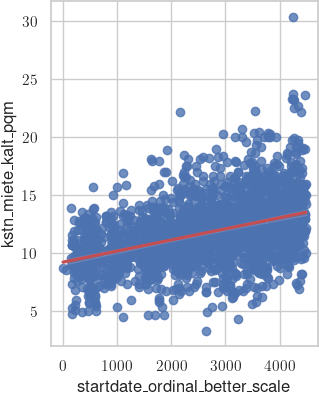

In [103]:
ax = sns.regplot(
    data=df_w_loc_interesting_copy,
    x='startdate_ordinal_better_scale',
    y='kstn_miete_kalt_pqm',
    line_kws=dict(color="r")

)

In [104]:
lg_df = pd.DataFrame(columns=["oadr_u2", "r_sq", "intercept", "slope"])
df_w_loc_interesting_copy=df_w_loc_interesting_copy.sort_values(by=["oadr_u2", 'startdate_ordinal'])
df_w_loc_interesting_copy["startdate_ordinal_better_scale"] = df_w_loc_interesting_copy["startdate_ordinal"] - df_w_loc_interesting_copy["startdate_ordinal"].min()
for i in interesting_regions:
    x = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "startdate_ordinal"]

    y = df_w_loc_interesting_copy.loc[df_w_loc_interesting_copy["oadr_u2"] == i, "kstn_miete_kalt_pqm"]
    x = x.values.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    intercept = model.intercept_
    slope=model.coef_[0]
    lg_df = lg_df._append({"oadr_u2": i, "r_sq": r_sq, "intercept": intercept, "slope": slope}, ignore_index=True)
lg_df

/tmp/ipykernel_2240955/290351209.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lg_df = lg_df._append({"oadr_u2": i, "r_sq": r_sq, "intercept": intercept, "slope": slope}, ignore_index=True)


oadr_u2      r_sq   intercept     slope
0                    Zentrum  0.171994 -770.666111  0.001062
1                Universität  0.136493 -614.075777  0.000849
2                      Wanne  0.237278 -722.686757  0.000997
3  Schönblick/Waldhäuser Ost  0.183645 -672.131696  0.000927

/tmp/ipykernel_2240955/4254574600.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


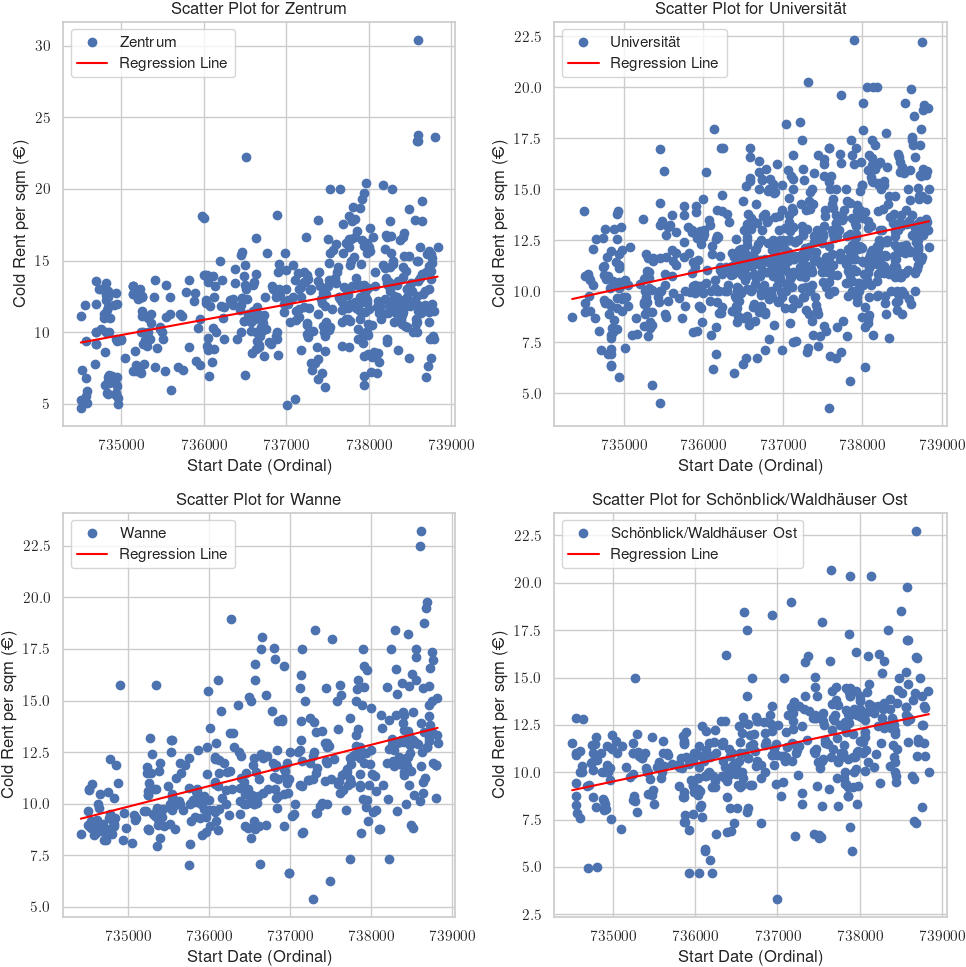

In [105]:


import matplotlib.dates as mdates
# Creating scatter plot with regression line
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows and 2 columns of plots

for i, region in enumerate(interesting_regions):
    # Filter data for each region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Plotting scatter plot for each region
    ax = axs[i//2, i%2]
    ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    # Adding regression line
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    ax.plot(x, y, color='red', label='Regression Line')

    ax.set_title(f'Scatter Plot for {region}')
    ax.set_xlabel('Start Date (Ordinal)')
    ax.set_ylabel('Cold Rent per sqm (€)')
    ax.legend()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

/tmp/ipykernel_2240955/1554625149.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=12)
/tmp/ipykernel_2240955/1554625149.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=12)
/tmp/ipykernel_2240955/1554625149.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=12)
/tmp/ipykernel_2240955/1554625149.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=12)
/tmp/ipykernel_2240955/1554625149.py:28: UserWarning: The figure layout 

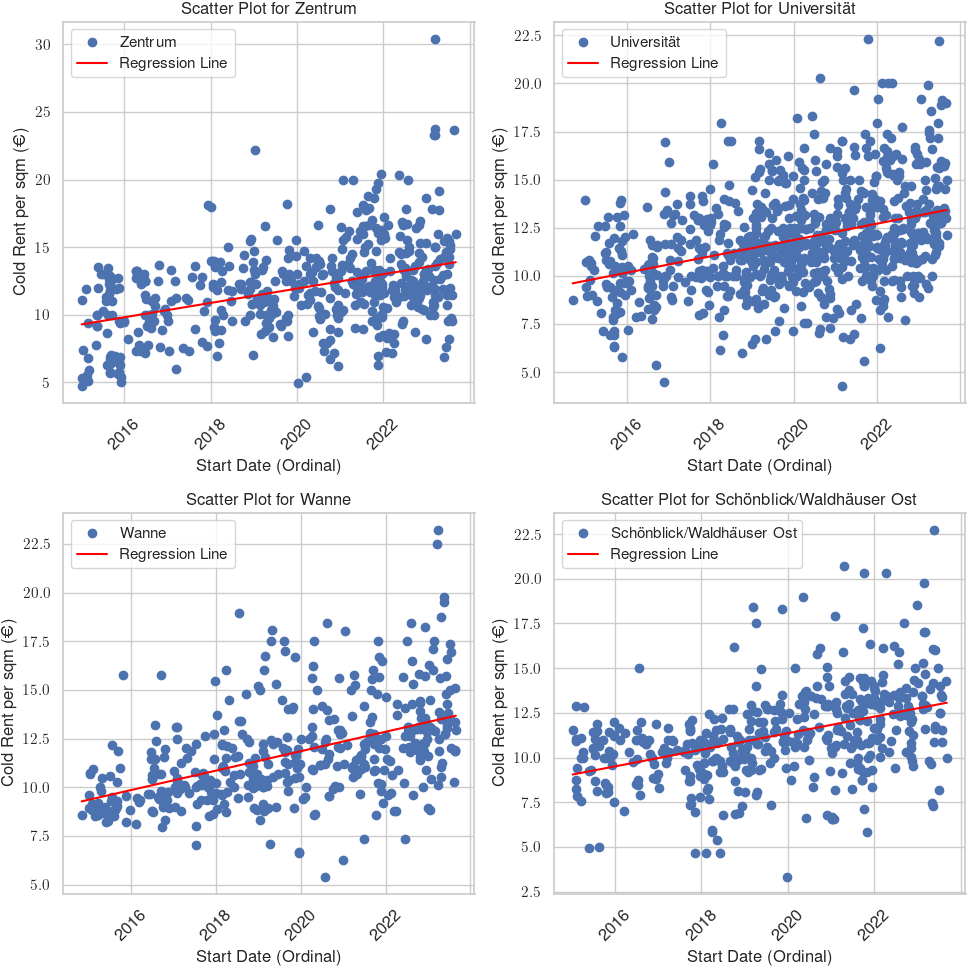

In [106]:


import matplotlib.dates as mdates
# Creating scatter plot with regression line
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows and 2 columns of plots

for i, region in enumerate(interesting_regions):
    # Filter data for each region
    region_data = df_w_loc_interesting_copy[df_w_loc_interesting_copy['oadr_u2'] == region]

    # Plotting scatter plot for each region
    ax = axs[i//2, i%2]
    ax.scatter(region_data['startdate_ordinal'], region_data['kstn_miete_kalt_pqm'], label=region)
    slope = lg_df.loc[lg_df["oadr_u2"] == region, "slope"].values[0]
    intercept = lg_df.loc[lg_df["oadr_u2"] == region, "intercept"].values[0]
    # Adding regression line
    x = np.array([region_data['startdate_ordinal'].min(), region_data['startdate_ordinal'].max()])
    y = slope * x + intercept
    ax.plot(x, y, color='red', label='Regression Line')

    ax.set_title(f'Scatter Plot for {region}')
    ax.set_xlabel('Start Date (Ordinal)')
    ax.set_ylabel('Cold Rent per sqm (€)')
    ax.legend()
    x_ticks_labels = ['2012','2016','2018','2020','2022']
    ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=12)
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

## rf

In [107]:
df_w_loc

angebot_id  anz_parken  anz_zimmer  aus_alarmanlage_janein  \
16004  3040210896         NaN         4.0                       0   
15991    58854993         1.0         3.0                       0   
15992    53677475         1.0         3.0                       0   
15993    44458486         2.0         5.5                       0   
15995    43152961         2.0         4.0                       0   
...           ...         ...         ...                     ...   
34     3592611553         1.0         4.0                       0   
33     3592611568         1.0         3.0                       0   
32     3592611656         1.0         3.0                       0   
45     3592318756         1.0         1.0                       0   
1      3594016393         NaN         2.0                       0   

       aus_bad_dusche_janein  aus_bad_gaestewc_janein  \
16004                      0                        1   
15991                      1                        0   
15992                      0                        0   
15993                      0                        1   
15995                      0                        0   
...                      ...                      ...   
34                         0                        0   
33                         0                        0   
32                         0                        0   
45                         0                        0   
1                          1                        0   

       aus_bad_mit_fenster_janein  aus_bad_wanne_janein  \
16004                           0                     1   
15991                           1                     1   
15992                           1                     1   
15993                           0                     1   
15995                           0                     1   
...                           ...                   ...   
34                              0                     0   
33                              0                     0   
32                              0                     0   
45                              0                     0   
1                               0                     0   

       aus_heiz_alt_erdw_janein  aus_heiz_alt_solar_janein  \
16004                         0                          0   
15991                         0                          0   
15992                         0                          0   
15993                         0                          0   
15995                         0                          0   
...                         ...                        ...   
34                            0                          0   
33                            0                          0   
32                            0                          0   
45                            0                          0   
1                             0                          0   

       aus_heiz_alt_pellet_janein  aus_heiz_alt_pumpe_janein  \
16004                           0                          0   
15991                           0                          0   
15992                           0                          0   
15993                           0                          0   
15995                           0                          0   
...                           ...                        ...   
34                              0                          0   
33                              0                          0   
32                              0                          0   
45                              0                          0   
1                               0                          0   

       aus_heiz_blockkw_janein aus_heiz_befeuerung  \
16004                        0                  Öl   
15991                        0                 Gas   
15992                        0                 NaN   
15993                        0                  Öl   


In [108]:
# drop all nan values
interesting_cols = ["anz_zimmer", "aus_heiz_system", "aus_kueche_einbau_janein", "aus_pool_janein", "baujahr", "flaeche", "kstn_miete_kalt_pqm"]
# filter based on interesting_cols
df_w_loc_interesting_rf = df_w_loc[interesting_cols]
# replace every nan with 0
df_w_loc_interesting_rf = df_w_loc_interesting_rf.fillna(0)


non_numeric_columns = df_w_loc_interesting_rf.select_dtypes(exclude=[np.number]).columns



# Apply one-hot encoding
df_encoded = pd.get_dummies(df_w_loc_interesting_rf, columns=non_numeric_columns)


In [109]:
df_w_loc_interesting_rf

anz_zimmer aus_heiz_system  aus_kueche_einbau_janein  aus_pool_janein  \
16004         4.0         Zentral                         1                0   
15991         3.0         Zentral                         1                0   
15992         3.0         Zentral                         0                0   
15993         5.5         Zentral                         1                0   
15995         4.0         Zentral                         0                0   
...           ...             ...                       ...              ...   
34            4.0         Zentral                         0                0   
33            3.0         Zentral                         0                0   
32            3.0         Zentral                         0                0   
45            1.0               0                         0                0   
1             2.0               0                         1                0   

       baujahr  flaeche  kstn_miete_kalt_pqm  
16004      0.0    87.00                 7.24  
15991   2001.0    71.59                 0.00  
15992   1962.0    75.00                 0.00  
15993   1966.0   125.00                 9.68  
15995   1962.0    92.00                 0.00  
...        ...      ...                  ...  
34      2025.0    96.36                 0.00  
33      2025.0    67.66                 0.00  
32      2025.0    67.67                 0.00  
45      1991.0    30.00                19.00  
1       1980.0    50.00                15.00  

[11927 rows x 7 columns]

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
df = df_encoded
# Assuming df is your DataFrame and 'kstn_miete_kalt_pqm' is the target variable (price)
X = df.drop('kstn_miete_kalt_pqm', axis=1)  # Features
y = df['kstn_miete_kalt_pqm']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X_train.columns[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. feature flaeche (0.41590963719747753)
2. feature baujahr (0.3069336797260412)
3. feature anz_zimmer (0.13777821586276567)
4. feature aus_kueche_einbau_janein (0.0842579566330709)
5. feature aus_heiz_system_Zentral (0.020062011833336574)
6. feature aus_heiz_system_0 (0.019639420928862877)
7. feature aus_heiz_system_Etage (0.008851580685729565)
8. feature aus_heiz_system_Zimmer (0.005941020660134361)
9. feature aus_pool_janein (0.0006264764725811637)


In [111]:
import shap

# Initialize the SHAP values calculator
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


ModuleNotFoundError: No module named 'shap'

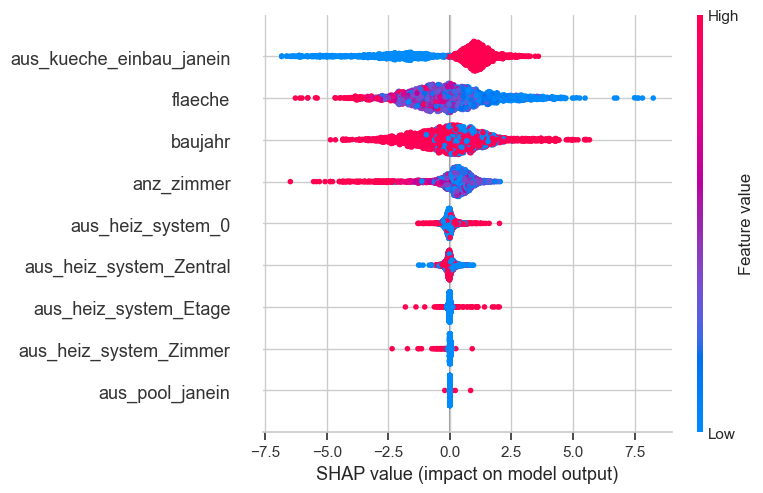

In [ ]:
# Create a summary plot for all the test set predictions
shap.summary_plot(shap_values, X_test)


In [ ]:
df_w_loc[df_w_loc["oadr_u2"].notna()]["baujahr"].isna().sum()

2106

In [ ]:
df_w_loc["oadr_u2"].isna().sum()

2796

In [ ]:
df_w_loc["baujahr"].isna().sum()

2872

## Maybe dont use toordinal, it messes up the x-axis

## What should we take for x ? 

# IGNORE

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf_2 = gpd.read_file("../data/tuebingen-regbez-latest-free/gis_osm_buildings_a_free_1.shp")

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf_2.plot(ax=ax, cmap='viridis', edgecolor='black', legend=True)

# Add labels and legend
plt.title('Tübingen, Germany - Regions')
plt.legend()

# Show the plot
plt.show()


DriverError: ../data/tuebingen-regbez-latest-free/gis_osm_buildings_a_free_1.shp: No such file or directory

In [ ]:
tuebingen_gdf_2.columns

In [ ]:
# init_path = "../data/tuebingen-regbez-latest-free/"
# shp_file_paths = ['gis_osm_buildings_a_free_1.shp', 'gis_osm_landuse_a_free_1.shp', 'gis_osm_natural_a_free_1.shp' ,'gis_osm_natural_free_1.shp', 'gis_osm_places_a_free_1.shp', 'gis_osm_places_free_1.shp','gis_osm_pofw_a_free_1.shp', '']

# # Create a list to store GeoDataFrames
# gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# # Create a larger plot with a specified size
# fig, ax = plt.subplots(figsize=(12, 12))

# # Plot each GeoDataFrame with a different color
# for i, gdf in enumerate(gdfs):
#     gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# # Add labels and legend
# plt.title('Combined Plot of Multiple Shapefiles')
# plt.legend()

# # Show the plot
# plt.show()


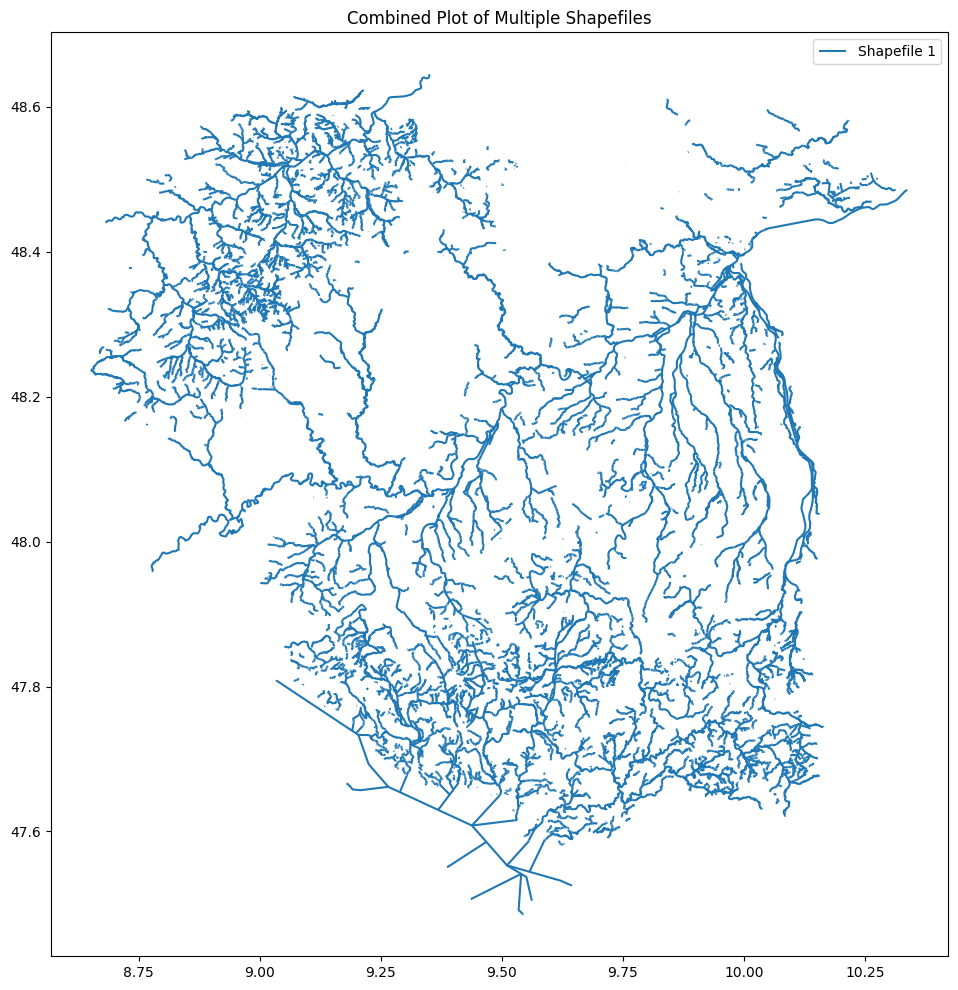

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_waterways_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()


/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_5419/38635465.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


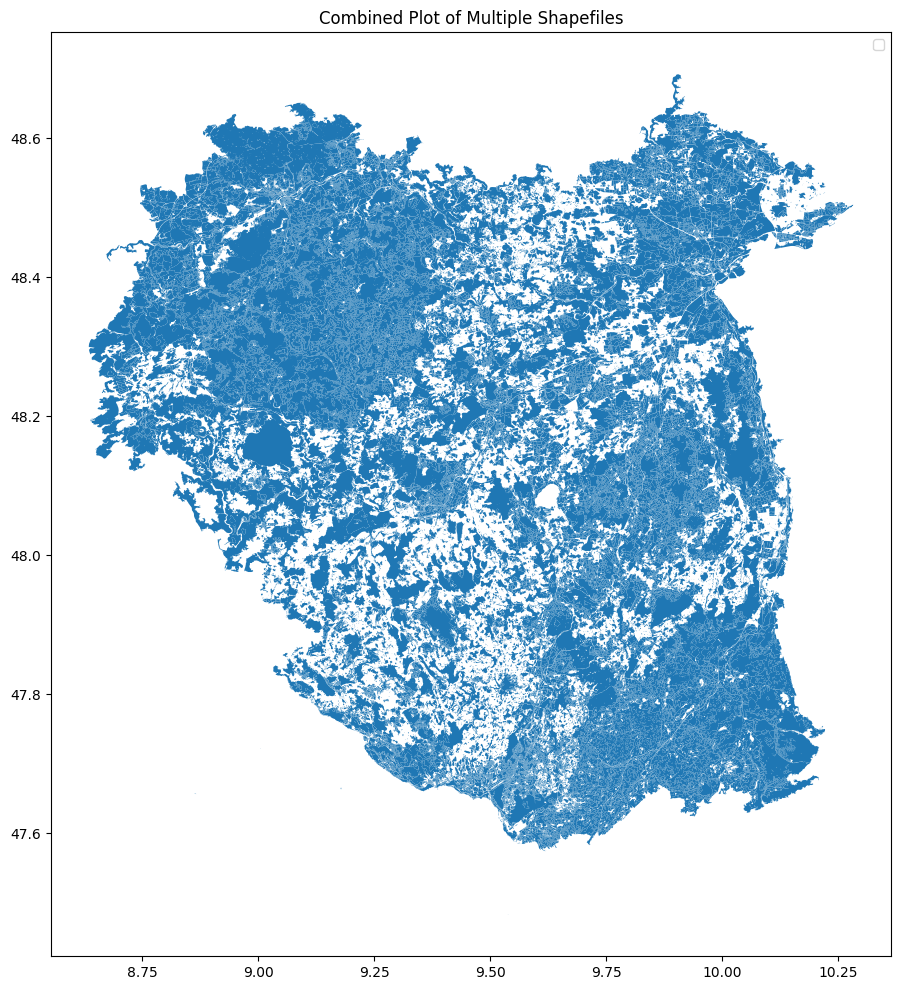

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_landuse_a_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()


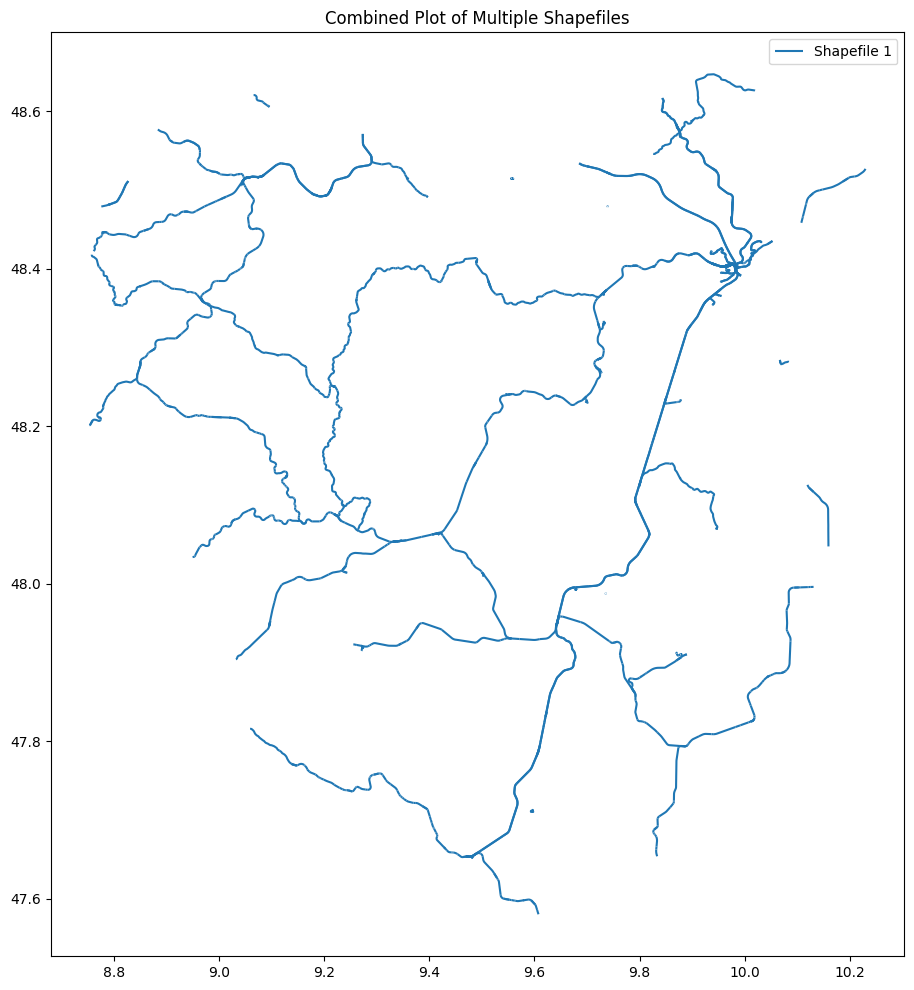

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_railways_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()
